# Question 1.1 Data Transformation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import glob
from datetime import datetime
import math
import csv
from sklearn.preprocessing import StandardScaler
import joblib

### Getting all unique parameters

In [2]:
# Define paths
csv_directory = "data/set-a/"
unique_parameters = set()

# Looping through each patient file and gathering the parameter name
for filename in os.listdir(csv_directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(csv_directory, filename)
        
        with open(file_path, mode='r') as file:
            reader = csv.reader(file)
            for row in reader:
                # Get row parameter name and add to set
                parameter = row[1]
                unique_parameters.add(parameter)

unique_parameters = list(unique_parameters)
unique_parameters.sort()
unique_parameters.remove("ICUType")
unique_parameters.remove("Parameter")

print("Unique Parameters:", unique_parameters)
print(len(unique_parameters))

Unique Parameters: ['ALP', 'ALT', 'AST', 'Age', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Gender', 'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'K', 'Lactate', 'MAP', 'MechVent', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RecordID', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'Weight', 'pH']
41


### Creating a large table for all patients

In [3]:
# Run this code for each of the sets once to create corresponding .parquet file (change folder names in lines 2 and 40 to "set-x")
file_paths = glob.glob("data/set-c/*.txt")

processed_dfs = []

# Loops through each of the patient .txt file and creates corresponding table. In the end, appends all tables to one big table and saves it as .parquet file
for file in file_paths:
    df = pd.read_csv(file)
    
    # For rounding to the next hour
    df[['Hour', 'Minute']] = df['Time'].str.split(':', expand=True).astype(int)
    df['RoundedHour'] = np.where((df['Hour'] == 0) & (df['Minute'] == 0), 0, ((df['Hour'] * 60 + df['Minute']) // 60 + 1) * 60)
    df['Time'] = df['RoundedHour'].apply(lambda x: f"{x//60:02}:00")

    # If we have two measurements during one hour (e.g, at 00:37 and at 00:57), we take the mean and get one value for the timestamp 01:00
    df_pivot = df.pivot_table(index='Time', columns='Parameter', values='Value', aggfunc='mean').reset_index()

    # Ensure all hours from 00:00 to 48:00 are present
    full_hours = pd.DataFrame({"Time": [f"{h:02}:00" for h in range(49)]})
    df_final = full_hours.merge(df_pivot, on="Time", how="left")

    # Add missing parameters from unique_parameters with NaN values (since not all parameters are measured on one patient)
    for param in unique_parameters:
        if param not in df_final.columns:
            df_final[param] = np.nan

    # Enforce static values to be persistent over all timestamps
    df_final["Age"] = df_final["Age"][0]
    df_final["Height"] = df_final["Height"][0]
    df_final["Weight"] = df_final["Weight"][0]
    df_final["Gender"] = df_final["Gender"][0]
    df_final["RecordID"] = df_final["RecordID"][0]

    processed_dfs.append(df_final)

final_df = pd.concat(processed_dfs, ignore_index=True)

# Saving result and displaying a preview
final_df.to_parquet('processed-data/processed-set-c.parquet', index=False)
final_df.head()

,Time,Age,BUN,Creatinine,DiasABP,FiO2,GCS,Gender,Glucose,HCO3,...,pH,ALP,ALT,AST,Albumin,Bilirubin,Cholesterol,MechVent,TroponinI,TroponinT
0,00:00,58.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01:00,58.0,NaN,NaN,53.000000,NaN,15.0,1.0,NaN,NaN,...,7.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02:00,58.0,11.0,0.5,56.666667,NaN,15.0,1.0,190.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,03:00,58.0,10.0,0.5,57.500000,NaN,15.0,1.0,160.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,04:00,58.0,NaN,NaN,53.000000,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting the labels from Outcomes-x.txt files and creating corresponding .parquet files

In [4]:
# Run this code for each of the sets once to create corresponding .parquet file (change folder names in lines 2 and 4 to "set-x")
df = pd.read_csv('data/Outcomes-c.txt')
df_labels = df[["RecordID","In-hospital_death"]]
df_labels.to_parquet('processed-data/processed-outcomes-c.parquet', index=False)

In [5]:
df_labels.head()

,RecordID,In-hospital_death
0,152871,0
1,152873,1
2,152875,0
3,152878,0
4,152882,0


# Q1.2 Exploratory Data Analysis

### Visualizing the data

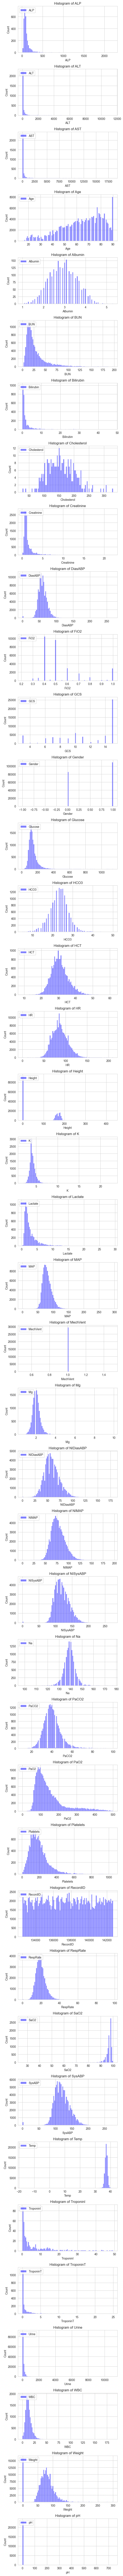

In [6]:
# Histograms of all parameters

df = pd.read_parquet('processed-data/processed-set-a.parquet')

N_points = 196000
n_bins = 100

fig, axs = plt.subplots(nrows=len(unique_parameters), ncols=1, figsize=(6, len(unique_parameters) * 3))

for i, e in enumerate(unique_parameters):
    current_row = np.array(df[e], dtype=float)
    # Remove NaNs
    current_row = current_row[~np.isnan(current_row)]  

    axs[i].hist(current_row, bins=n_bins, density=False, alpha=0.5, color='b', edgecolor='white')
    axs[i].set_title(f"Histogram of {e}")
    axs[i].set_xlabel(e)
    axs[i].set_ylabel("Count")
    axs[i].legend([e], loc='upper left')

plt.tight_layout()
plt.show()

### Observation

We can observe the typical normally distributed bell shape quite often. However, there are variables, we we can see a different pattern. For example, for both the variables "Height" and "Weight" it can be observed that their value is sometimes equal to "-1.0". We think that this is a different way of saying that there was no measurement taken for these variables at that point in time, meaning it should essentially be a NaN value. Additionally, the variable "Gender" is simply encoded as "1.0" or "0.0" standing for either male or female.



/var/folders/dn/rttvx1x53gg_p5nd3_nntb880000gn/T/ipykernel_1783/2765296964.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


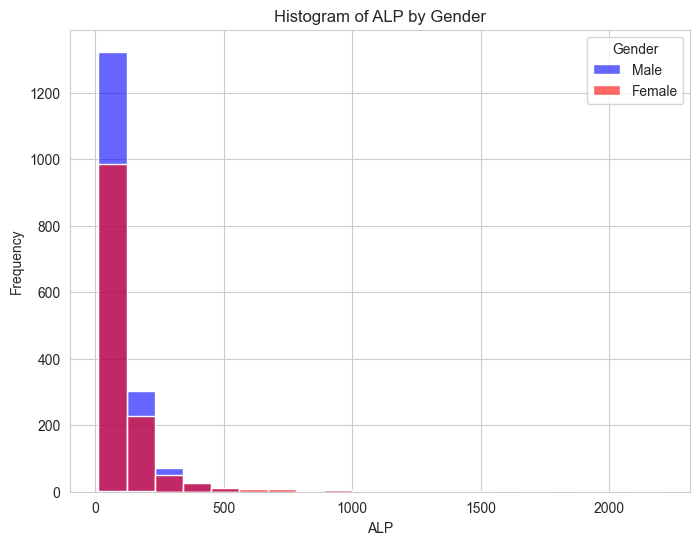

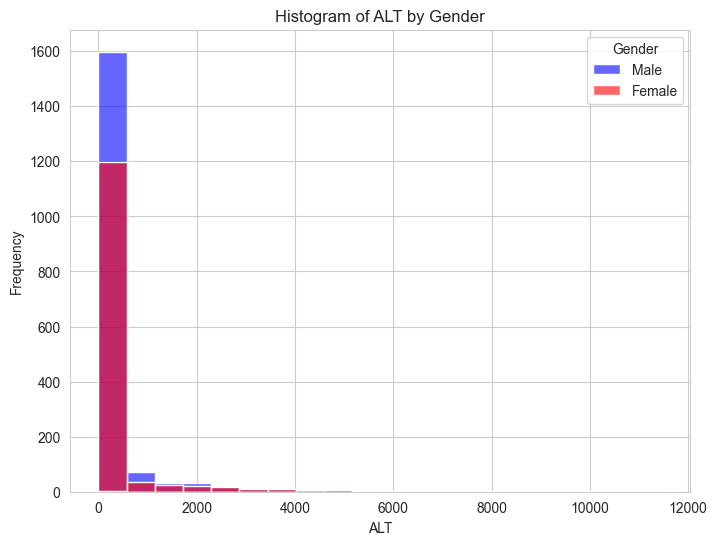

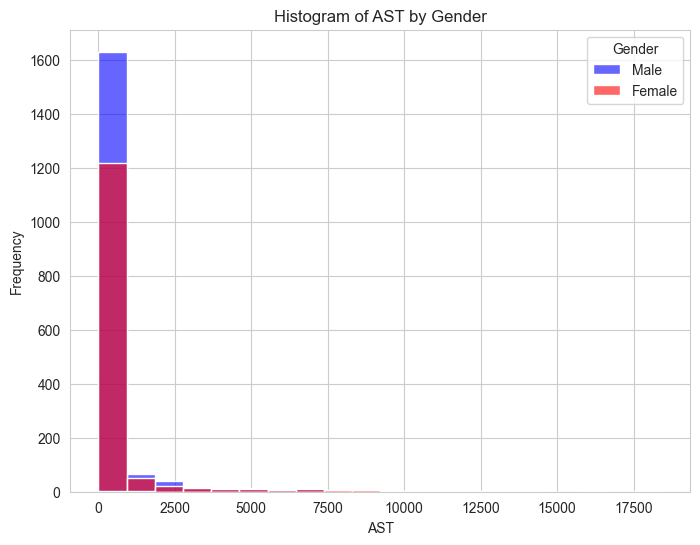

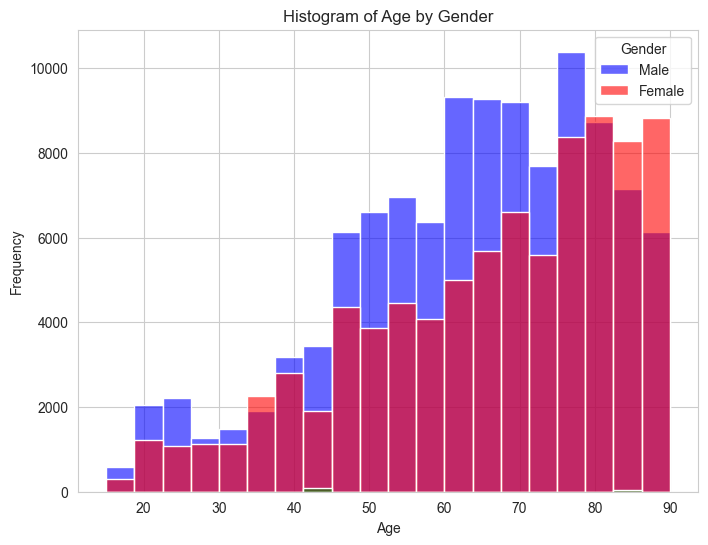

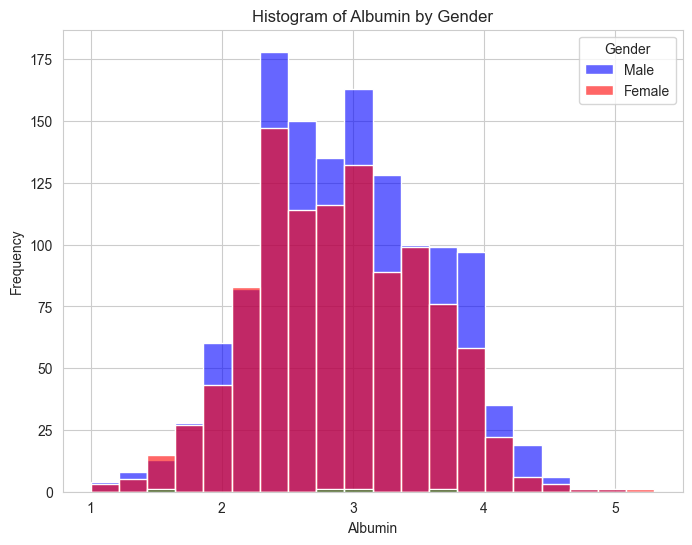

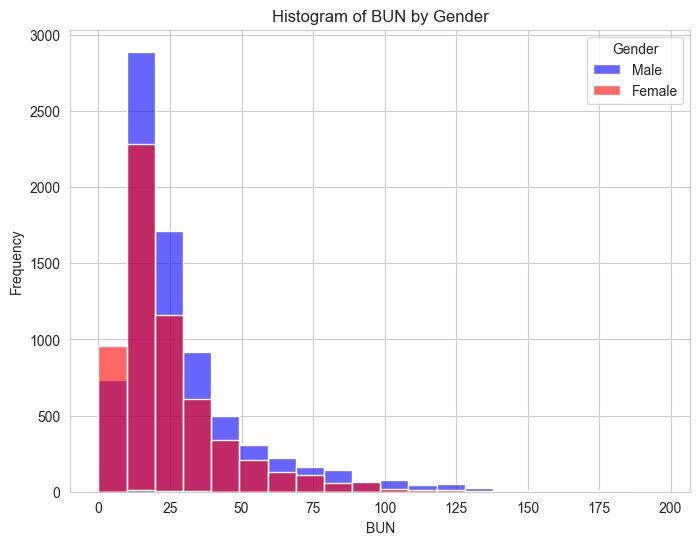

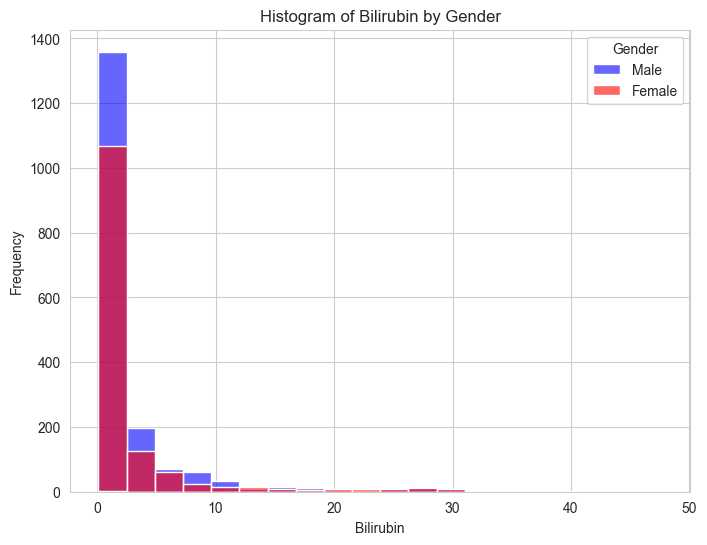

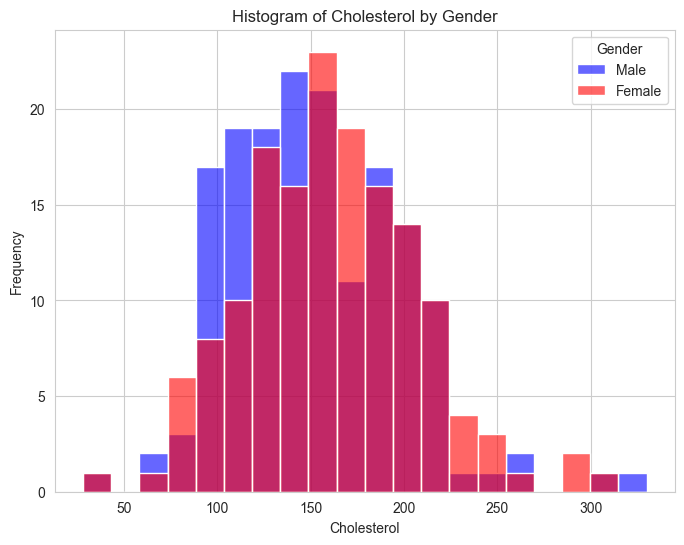

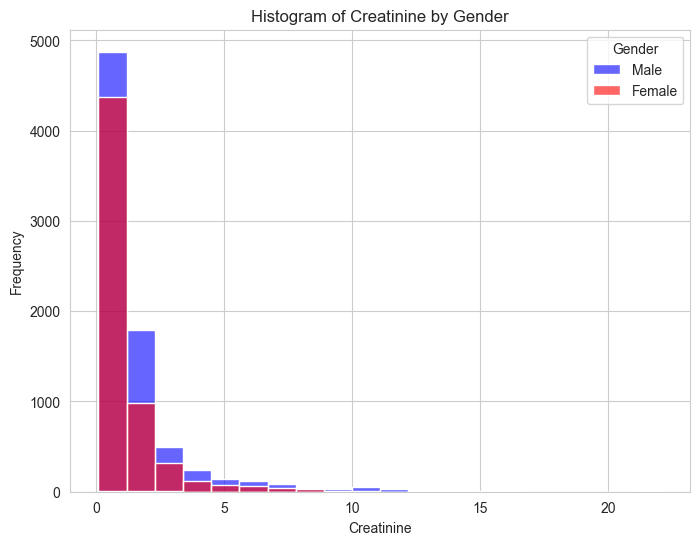

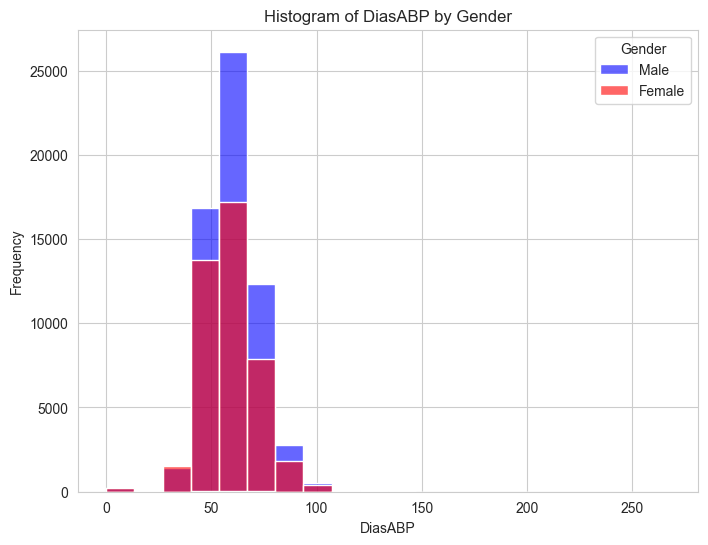

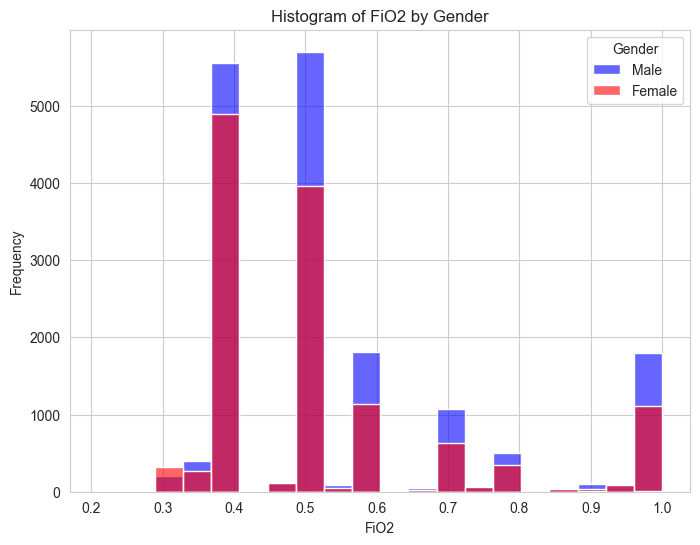

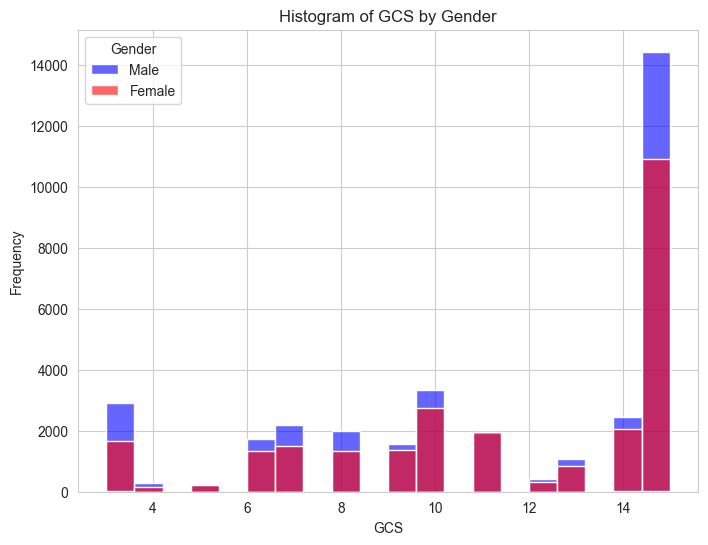

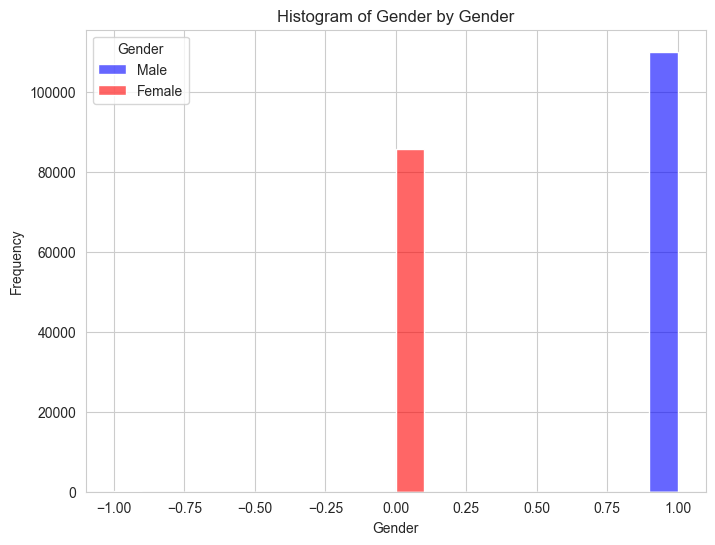

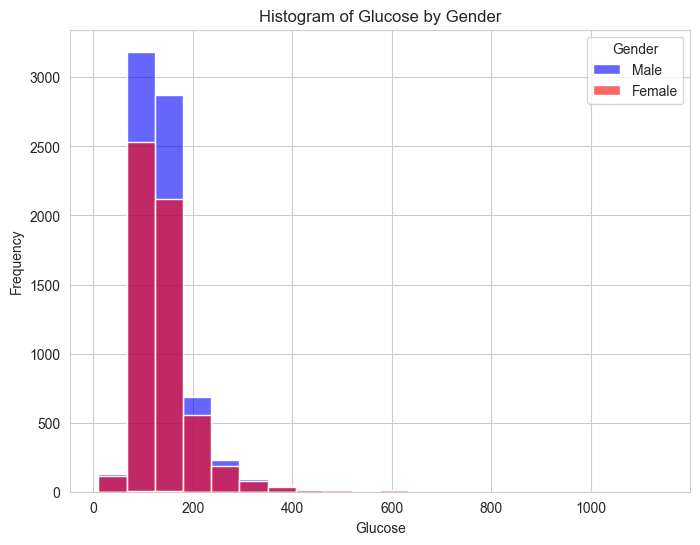

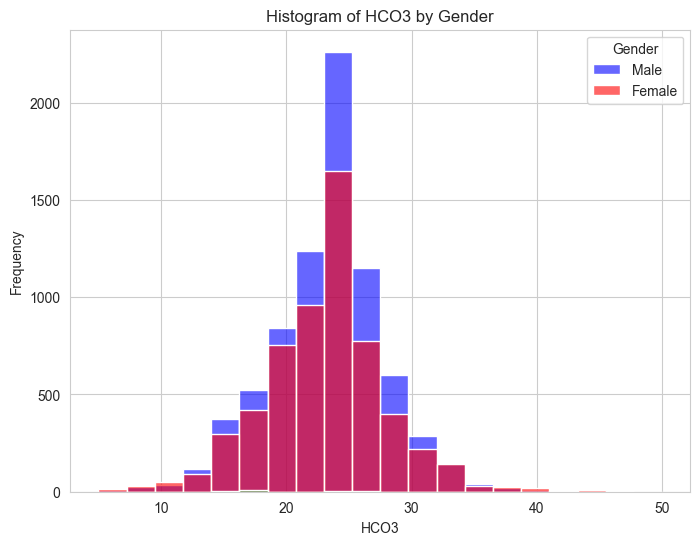

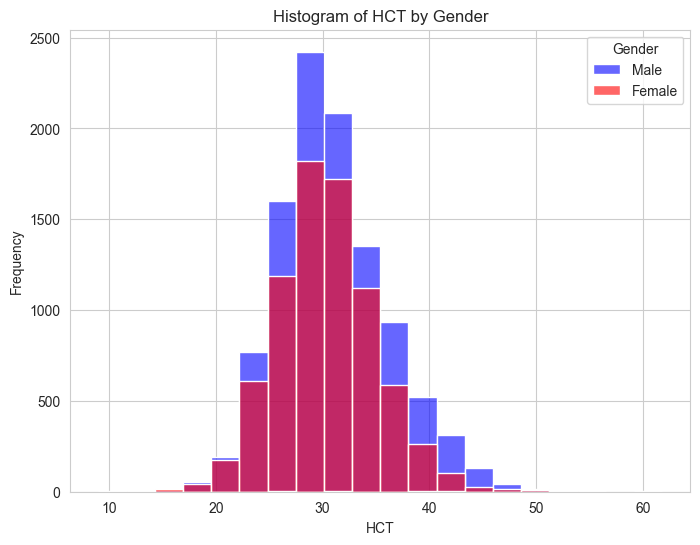

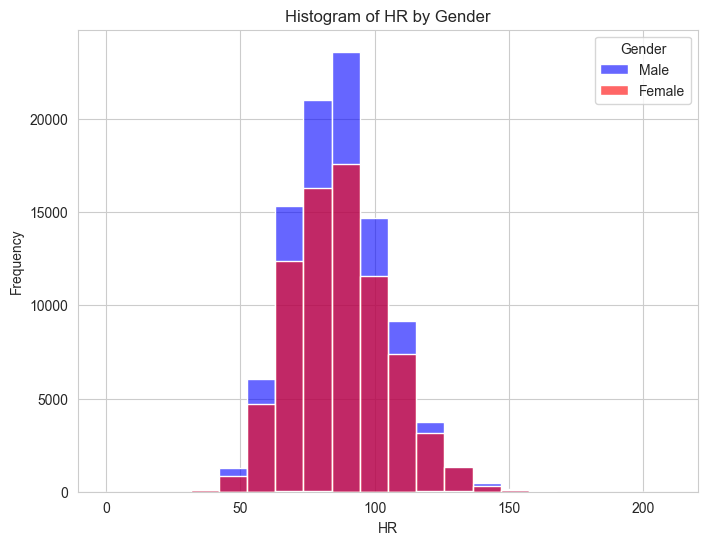

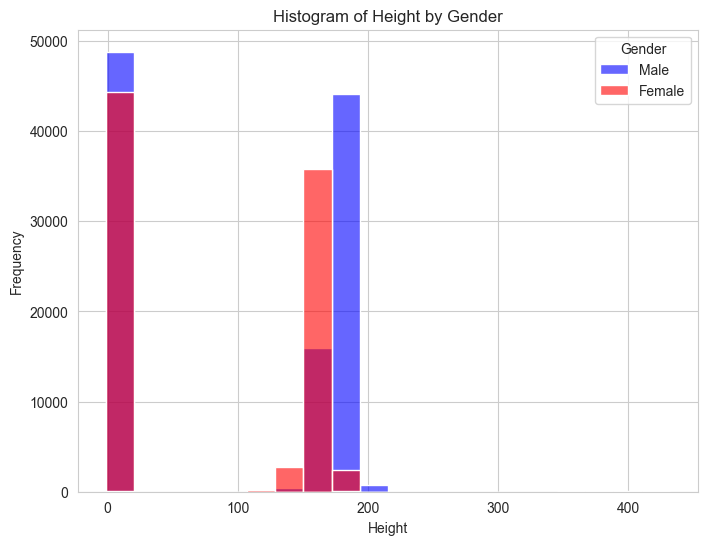

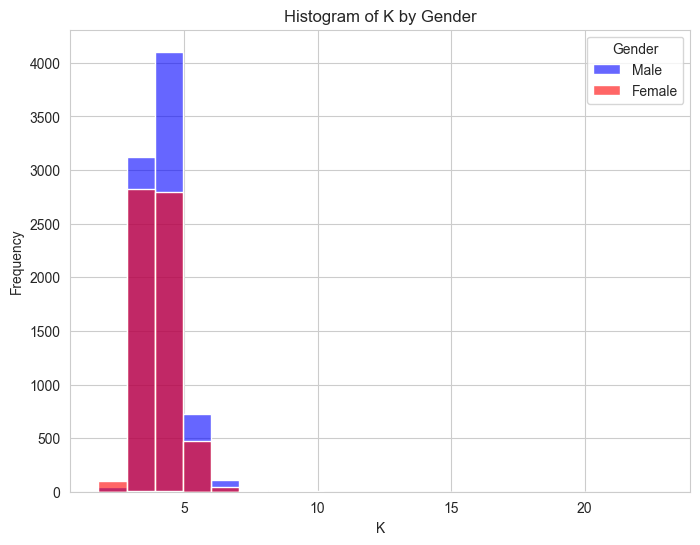

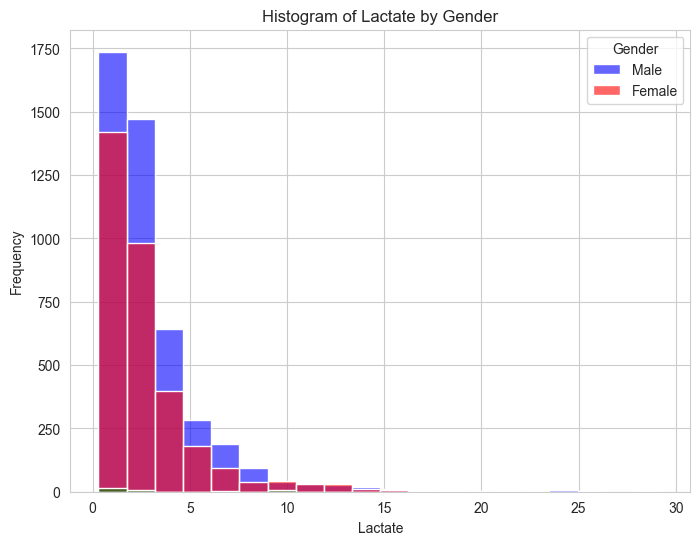

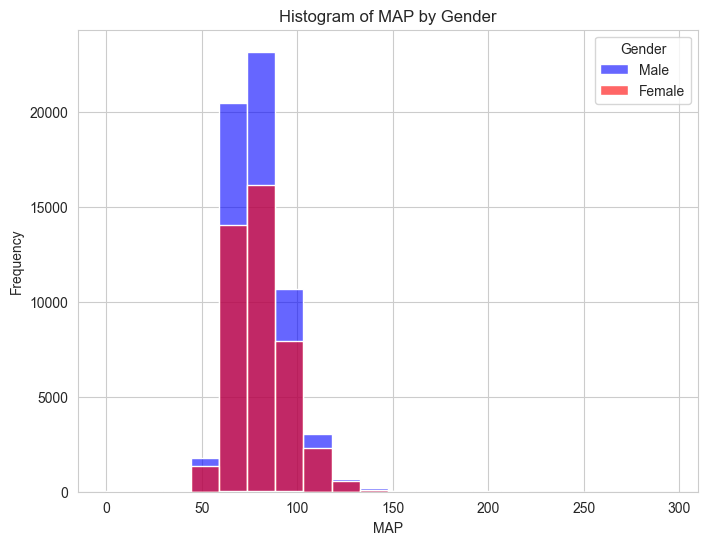

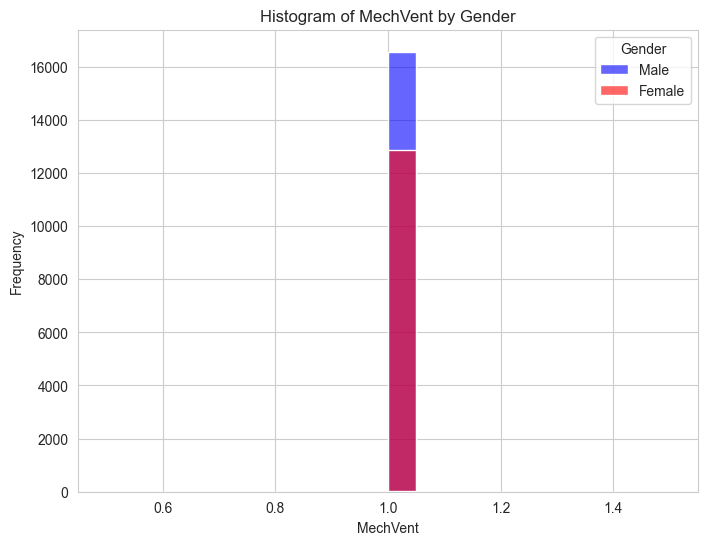

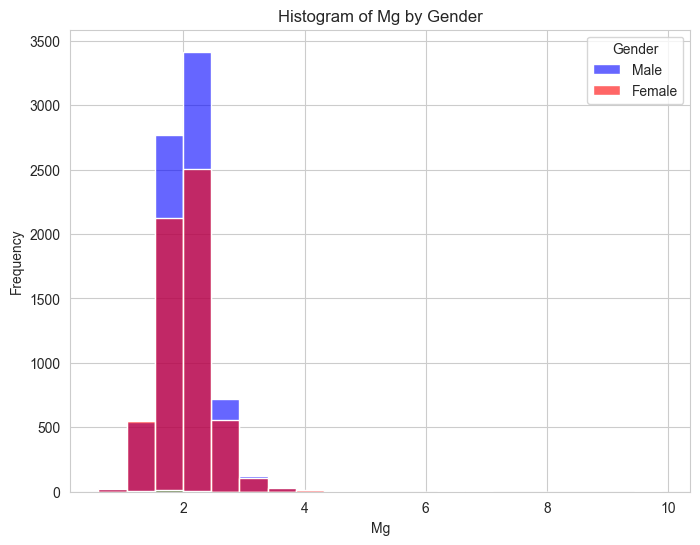

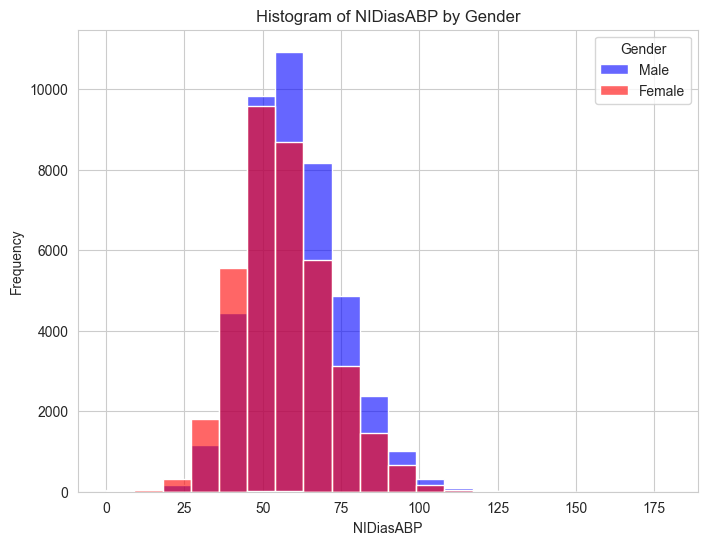

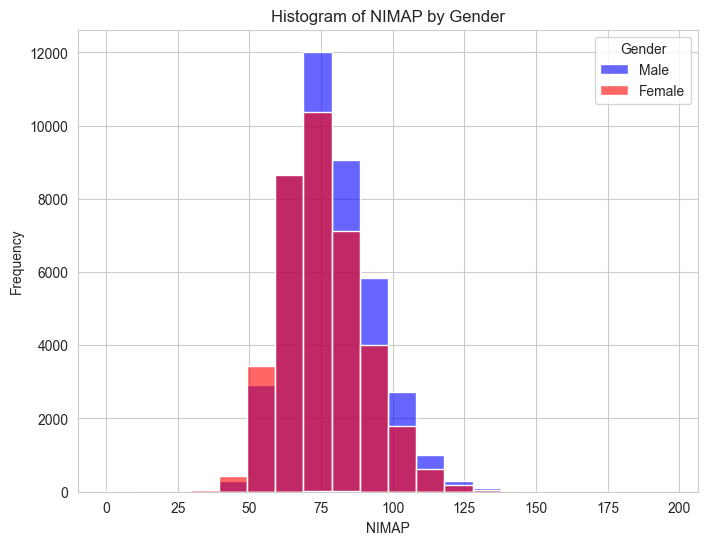

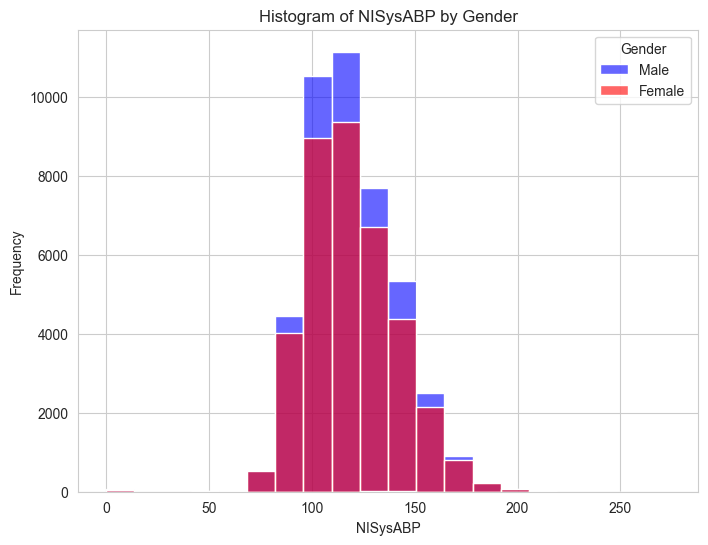

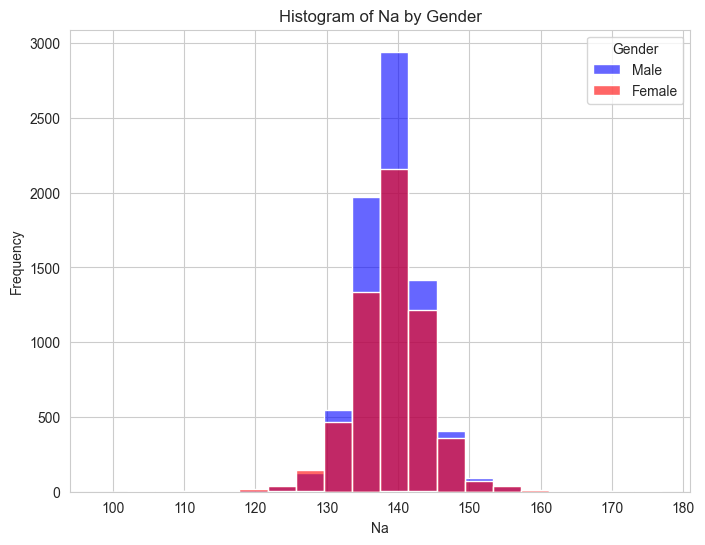

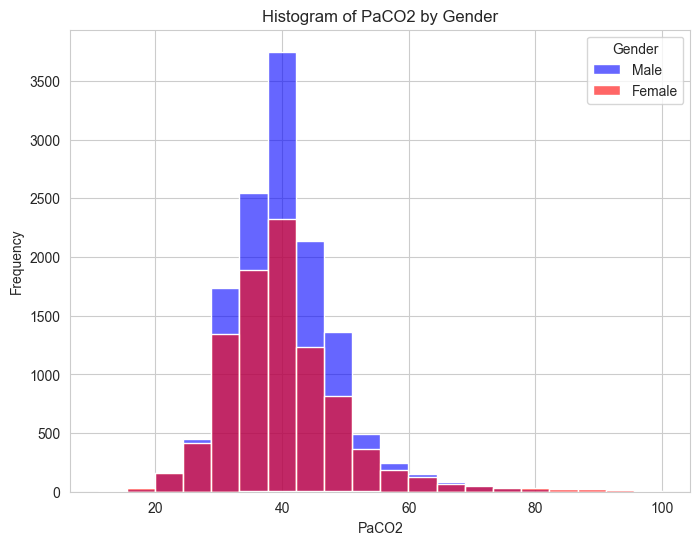

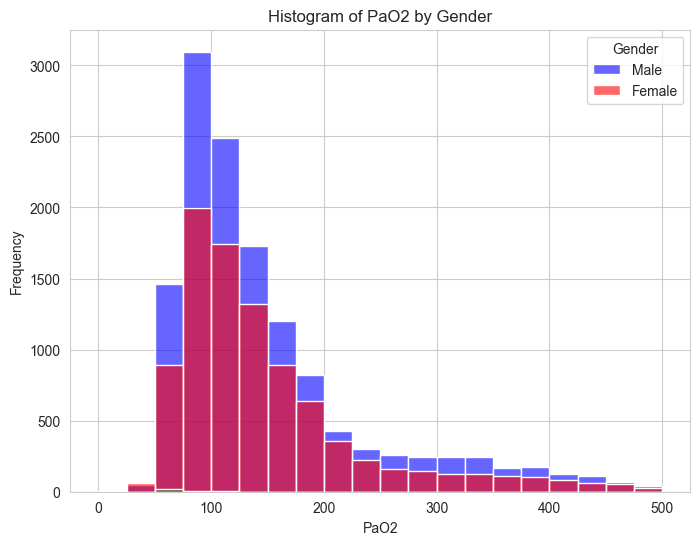

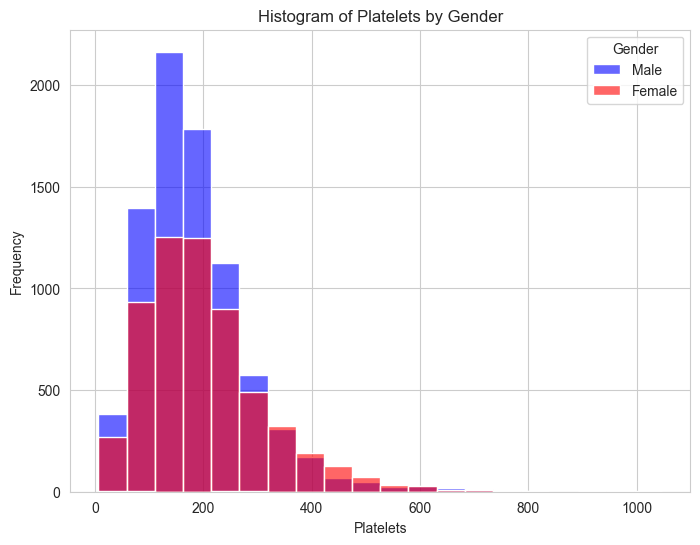

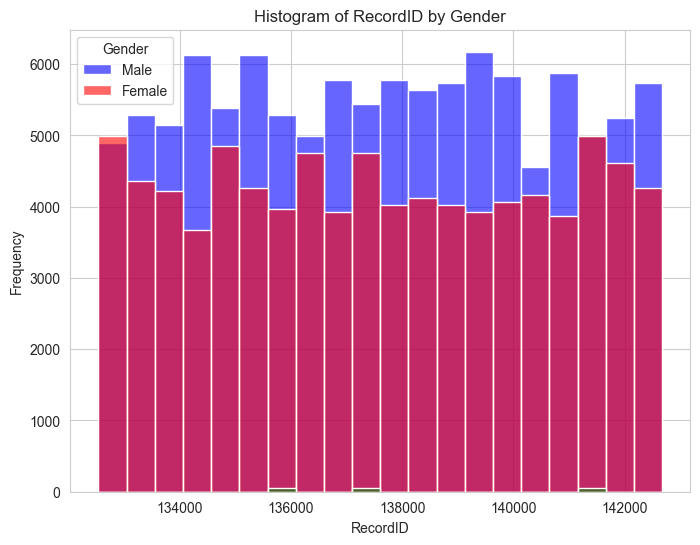

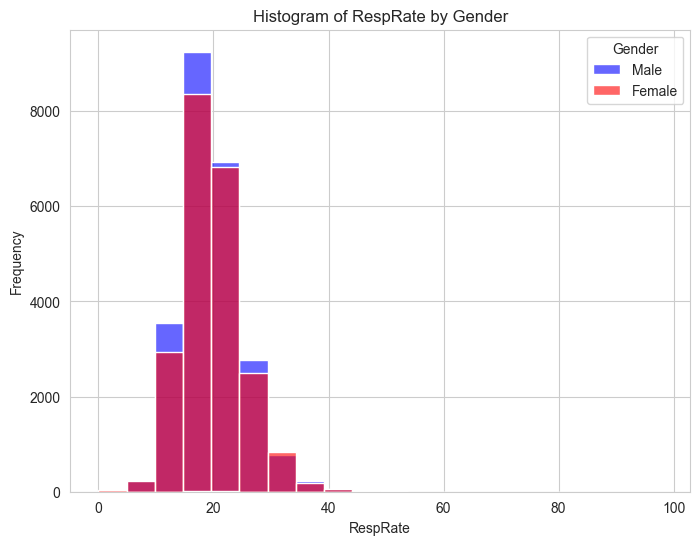

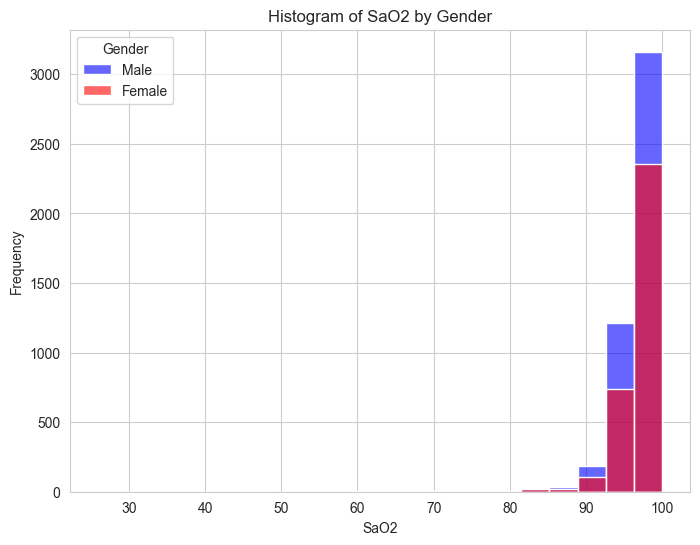

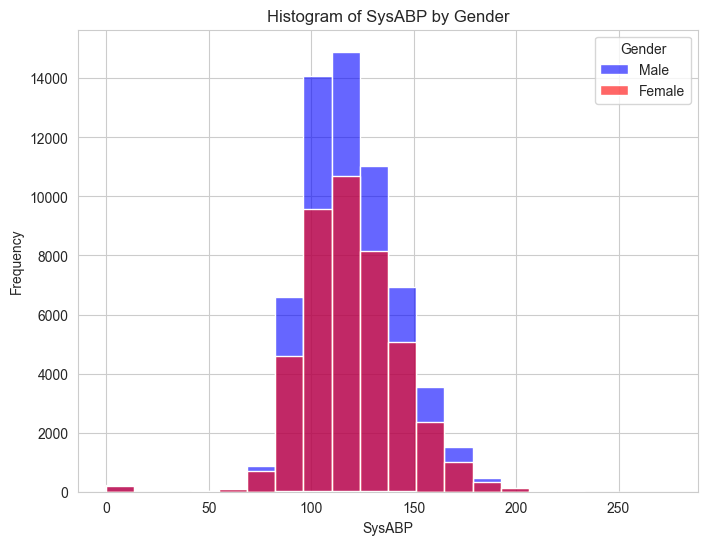

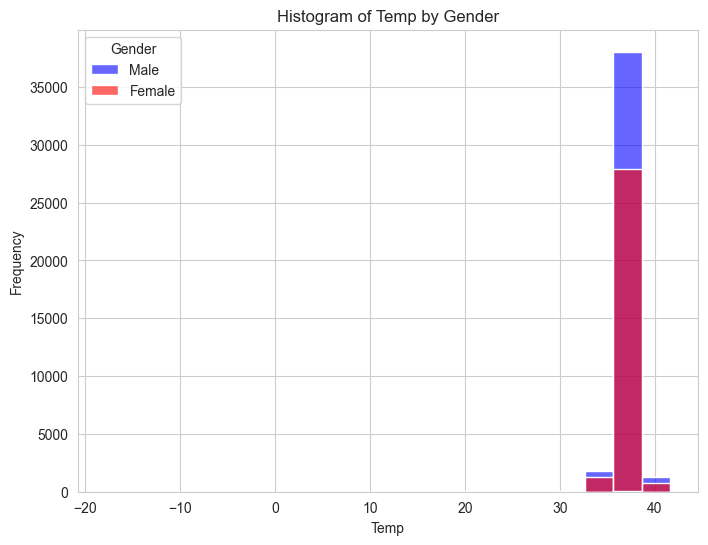

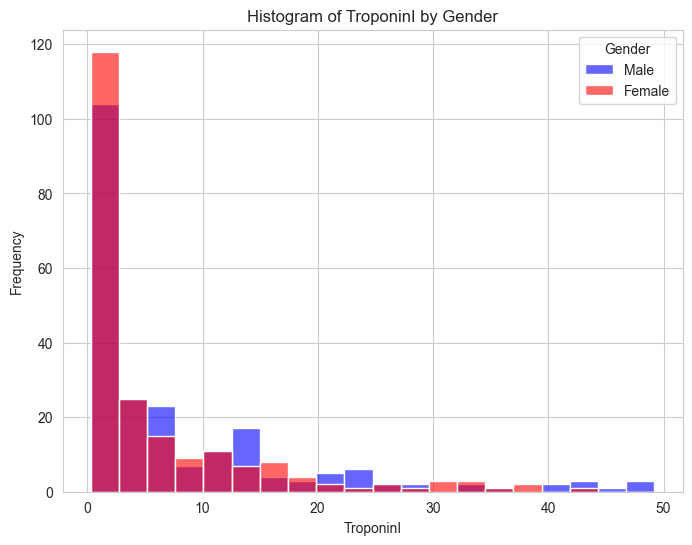

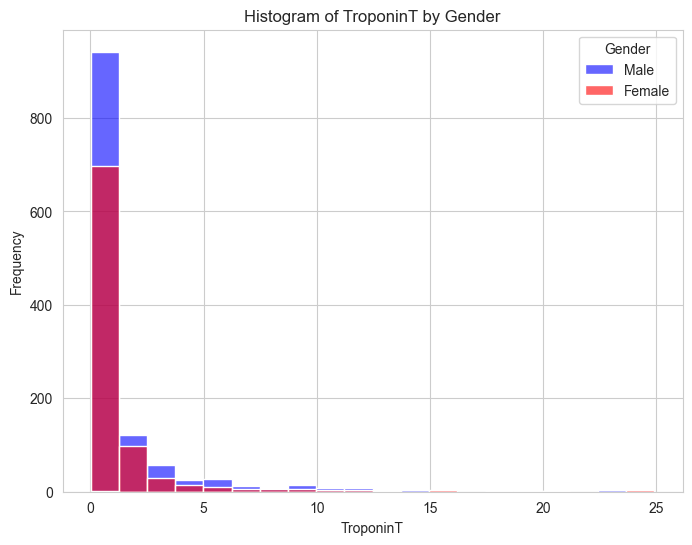

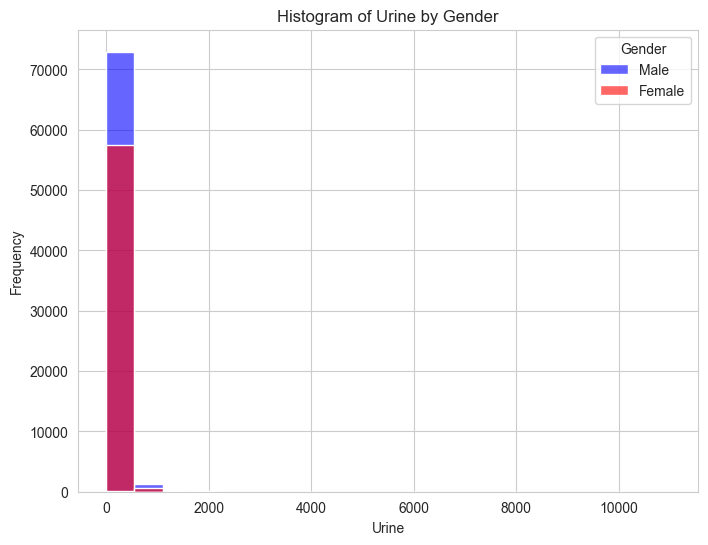

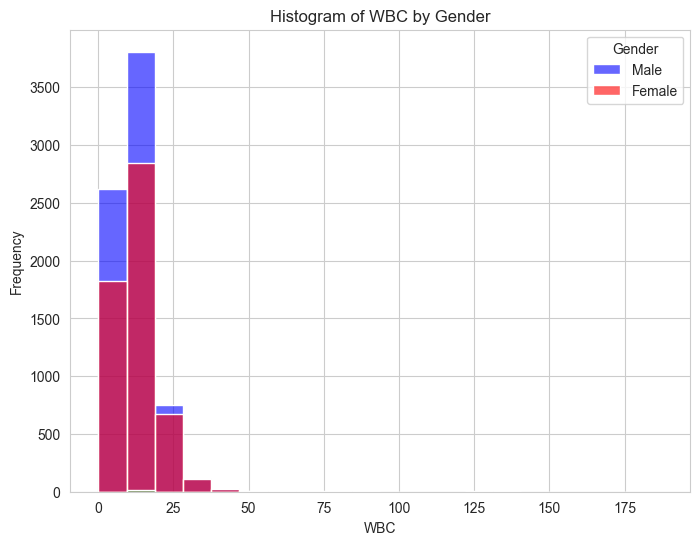

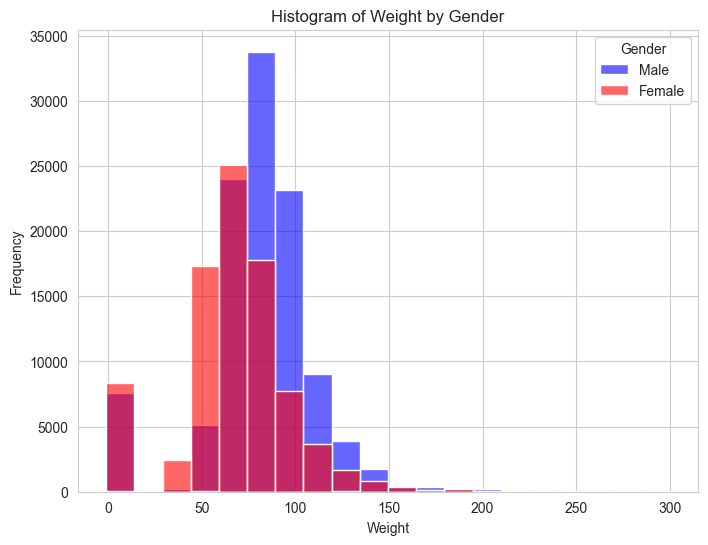

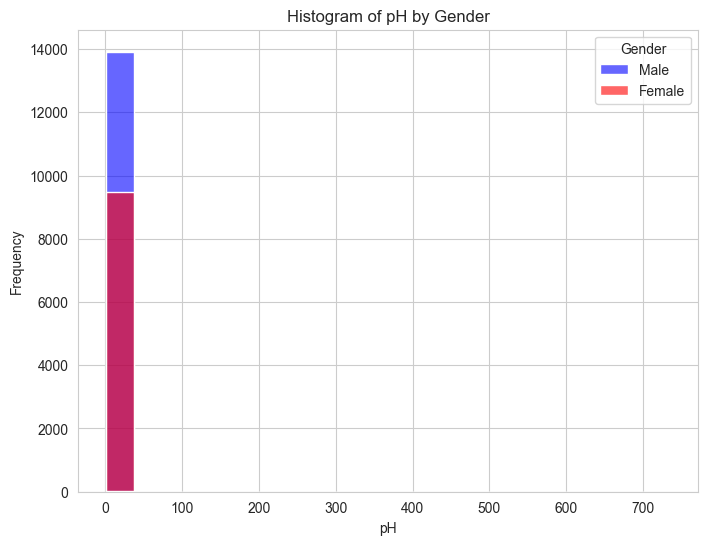

In [7]:
# Histograms of parameters by Gender

df = pd.read_parquet('processed-data/processed-set-a.parquet')

for e in unique_parameters:
    # Create a histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=e, hue="Gender", bins=20, alpha=0.6, palette={1.0: "blue", 0.0: "red", -1.0: "green"})

    plt.title("Histogram of " + e + " by Gender")
    plt.xlabel(e)
    plt.ylabel("Frequency")
    plt.legend(title="Gender",labels=["Male","Female"])
plt.show()

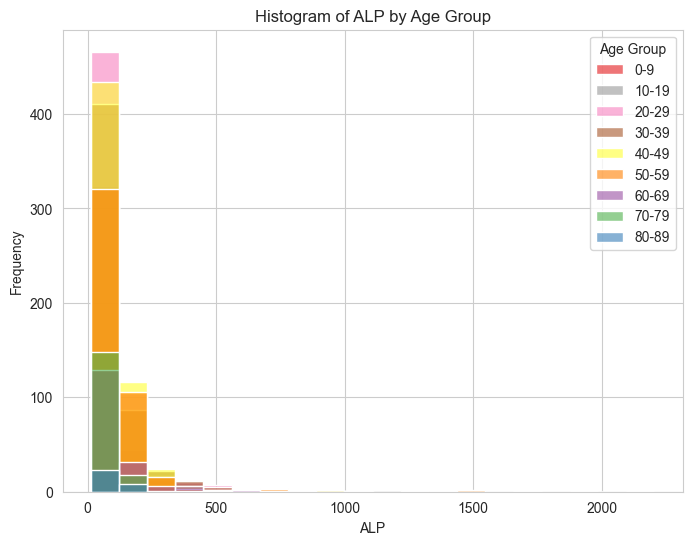

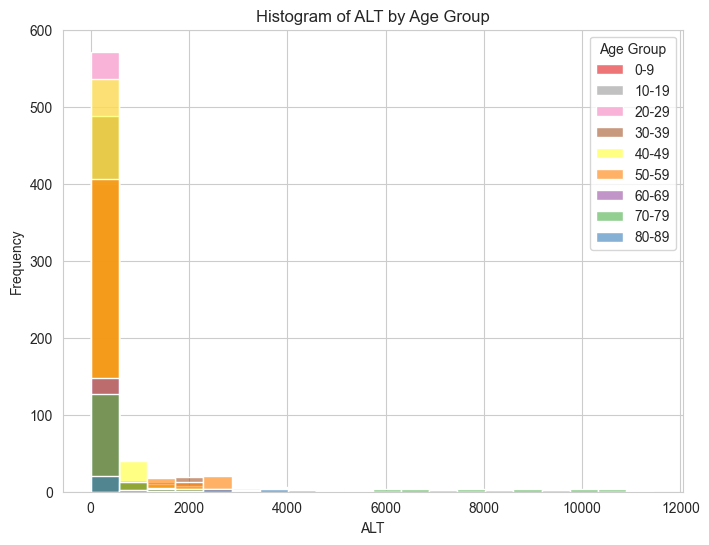

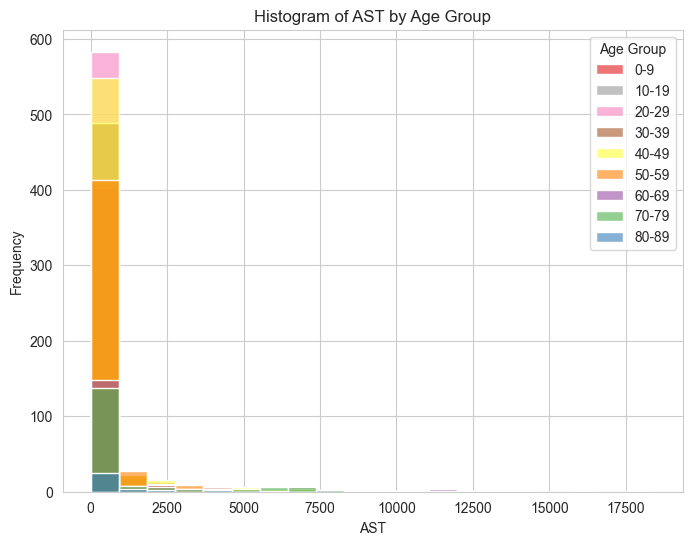

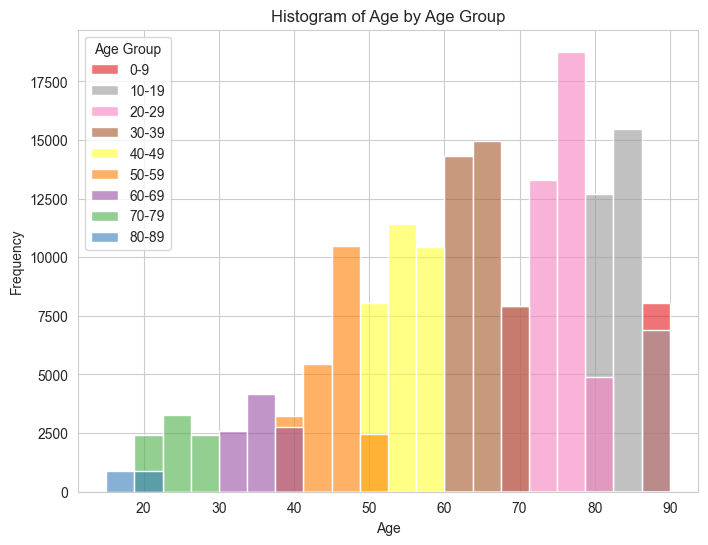

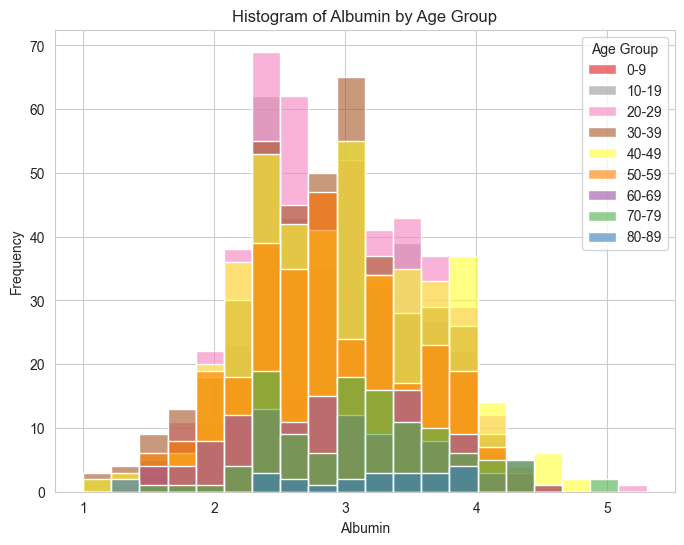

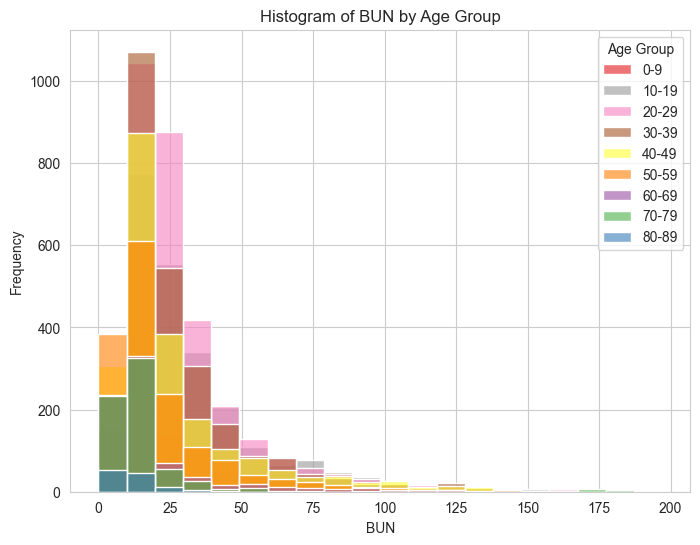

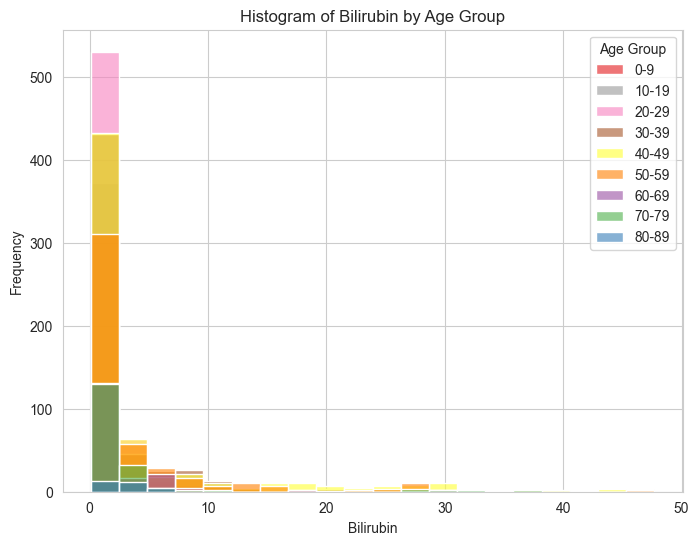

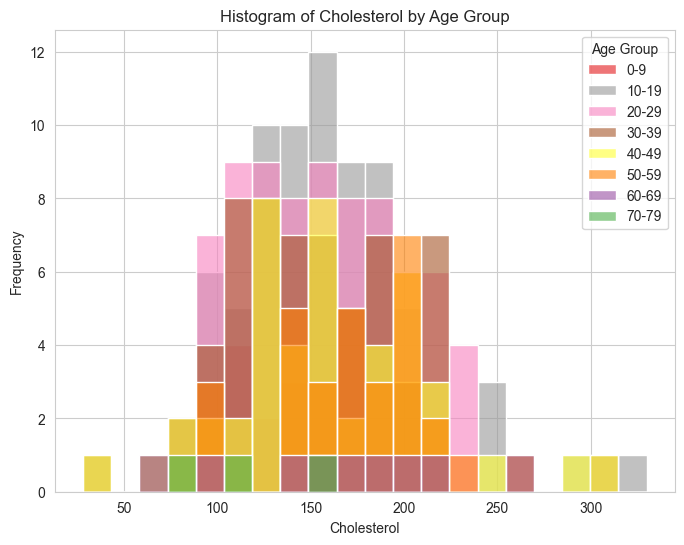

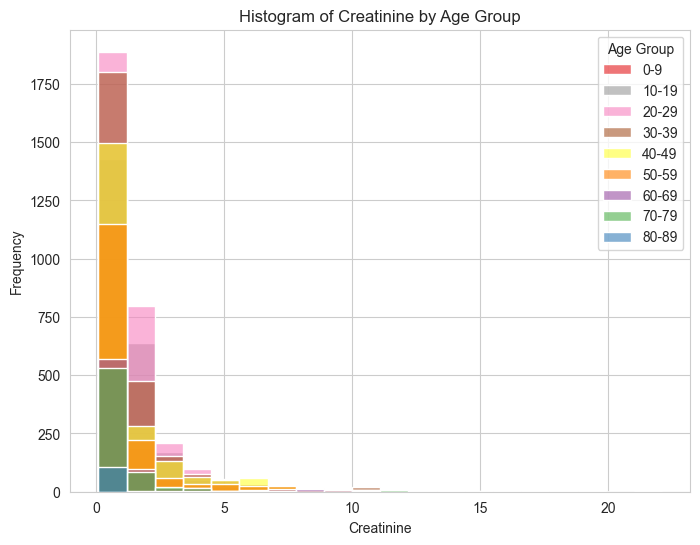

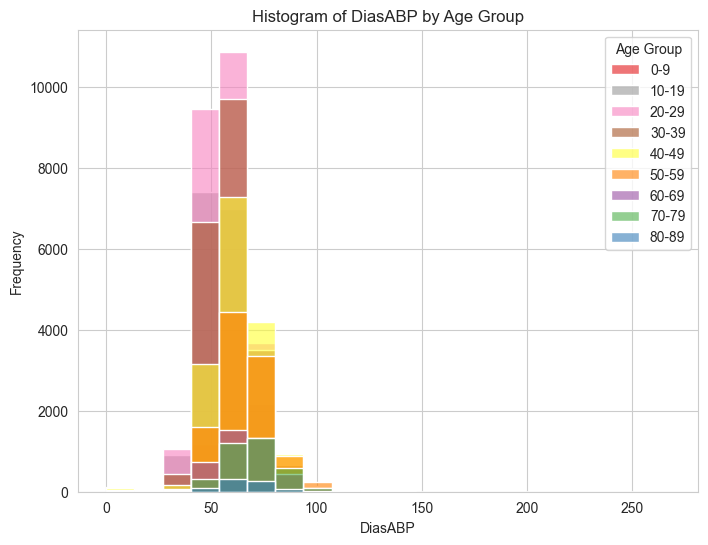

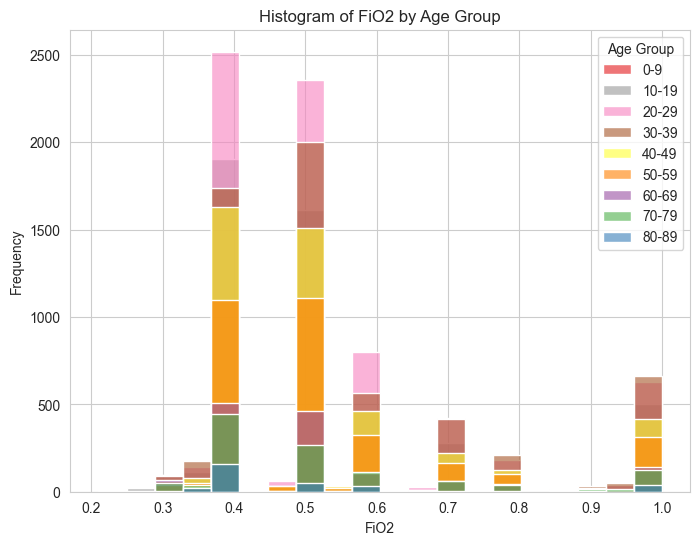

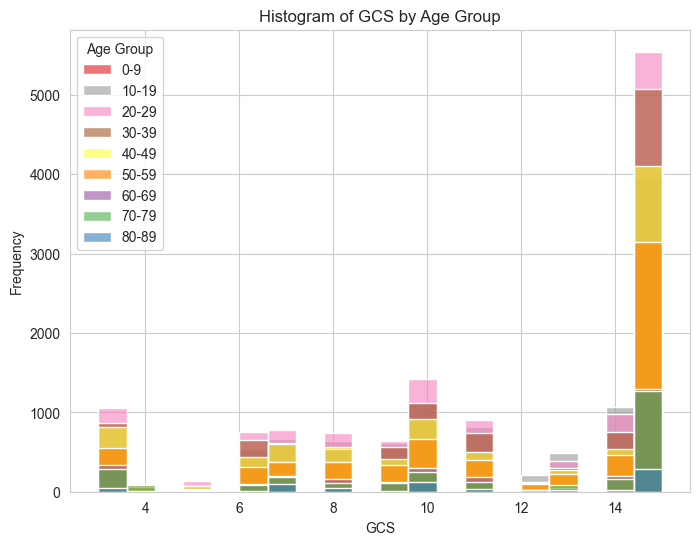

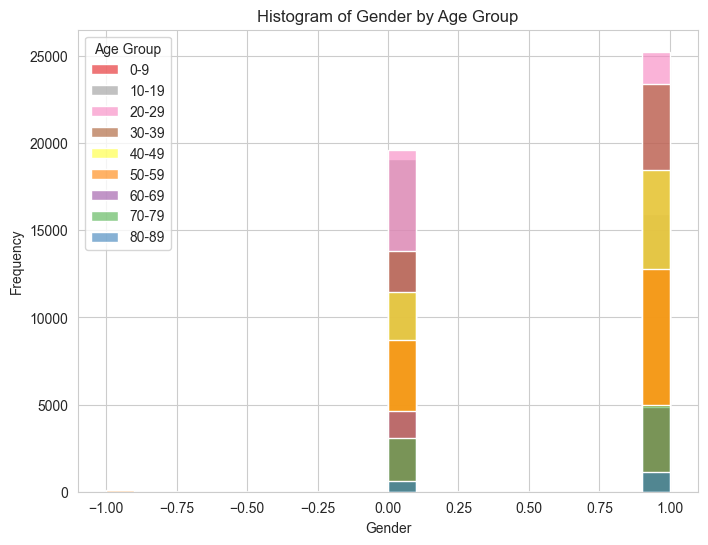

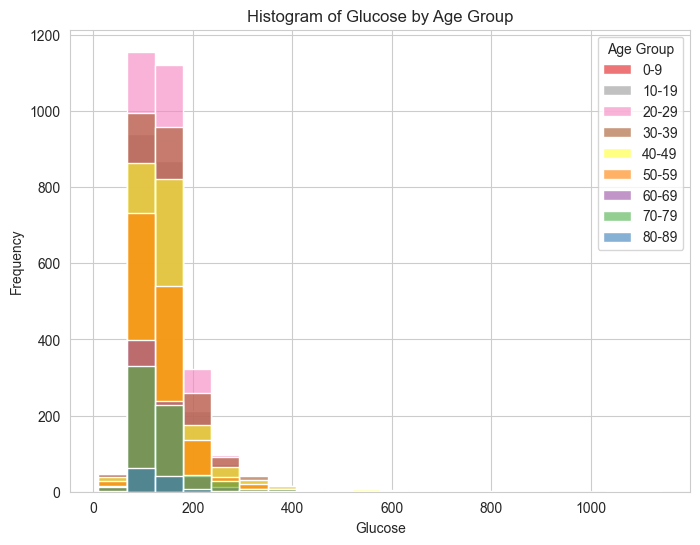

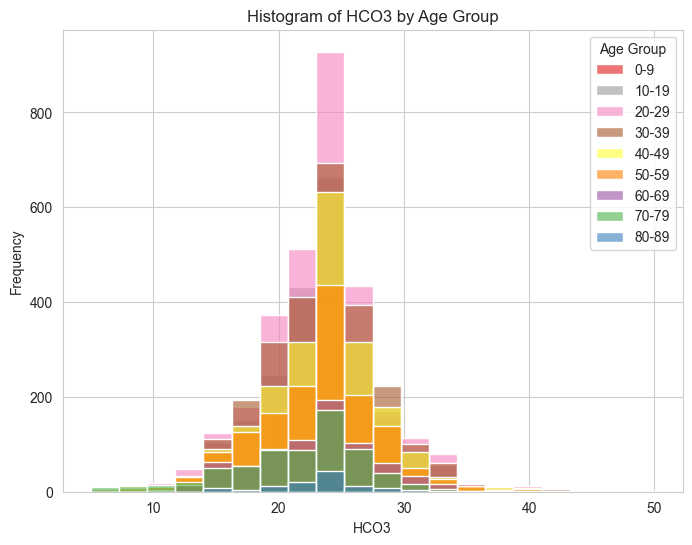

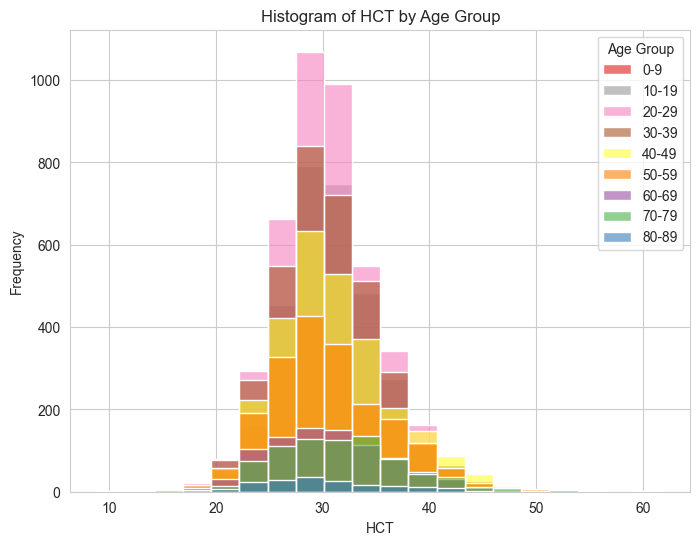

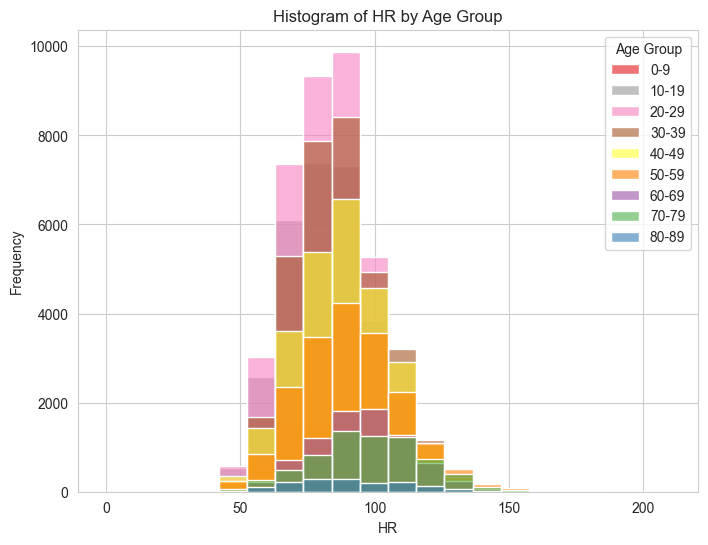

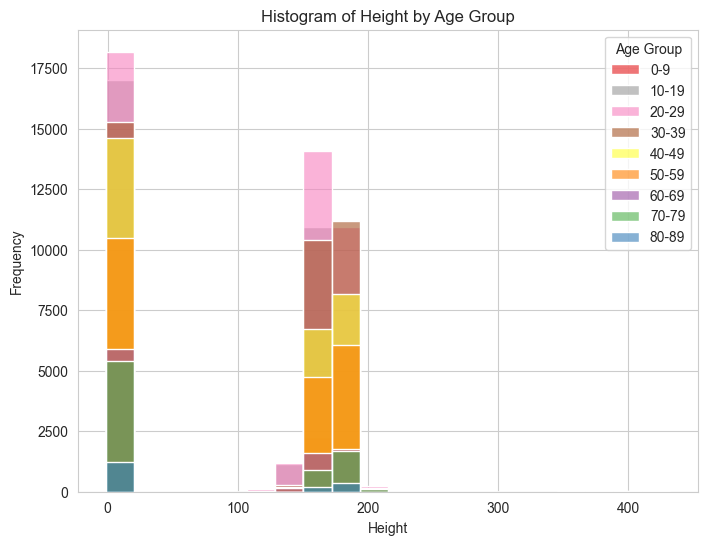

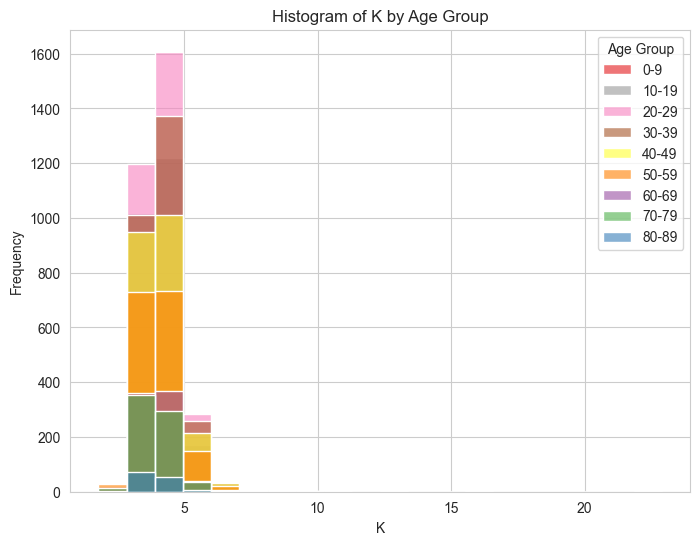

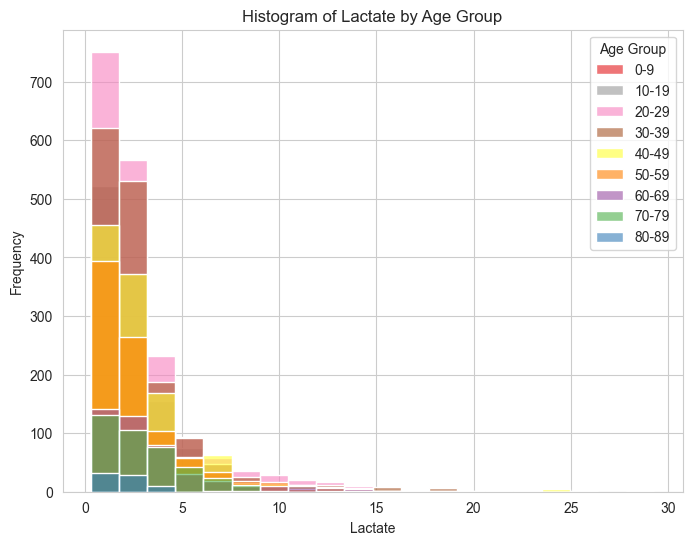

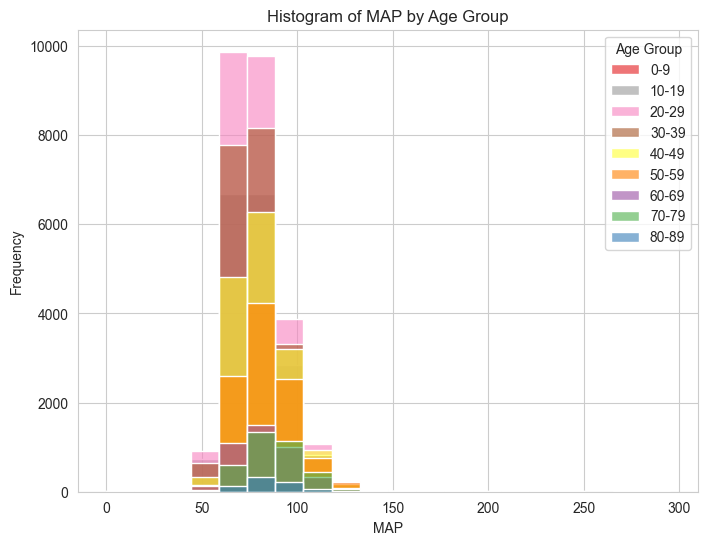

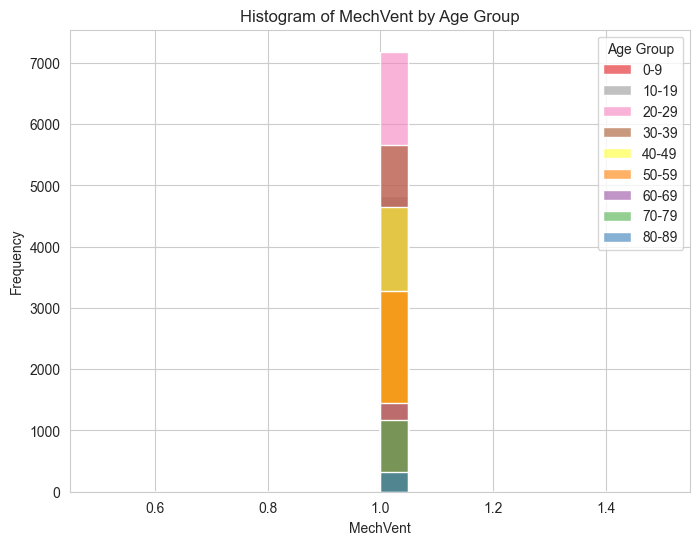

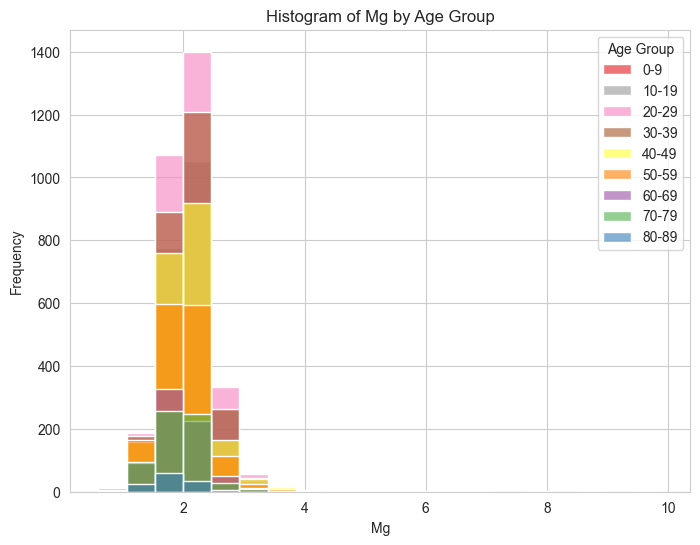

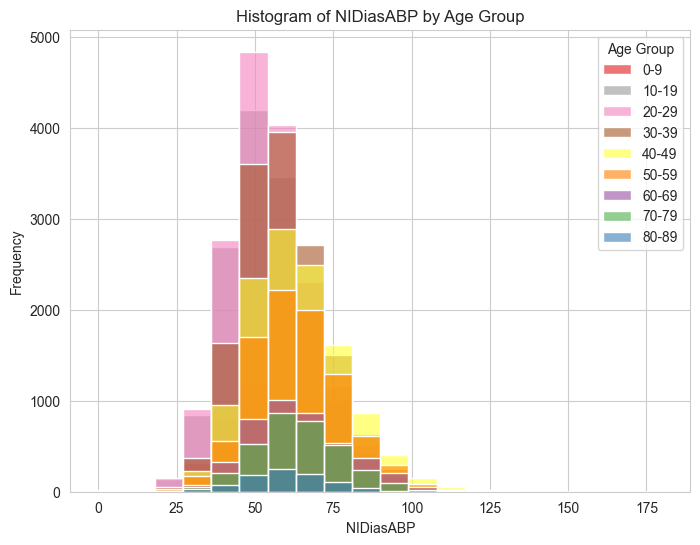

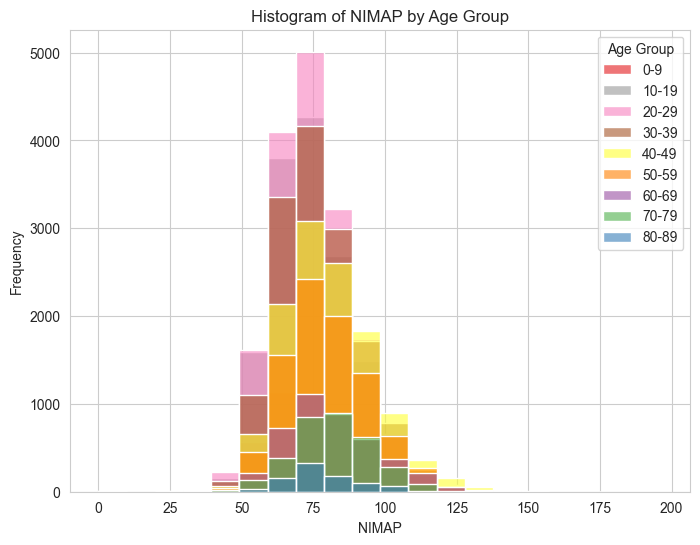

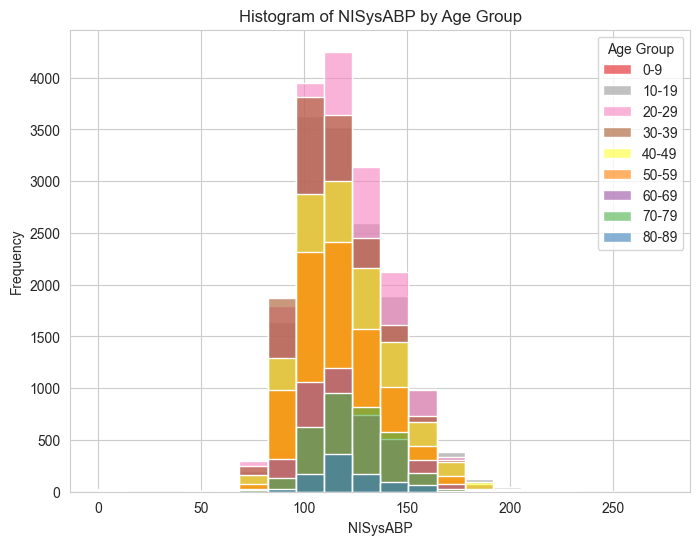

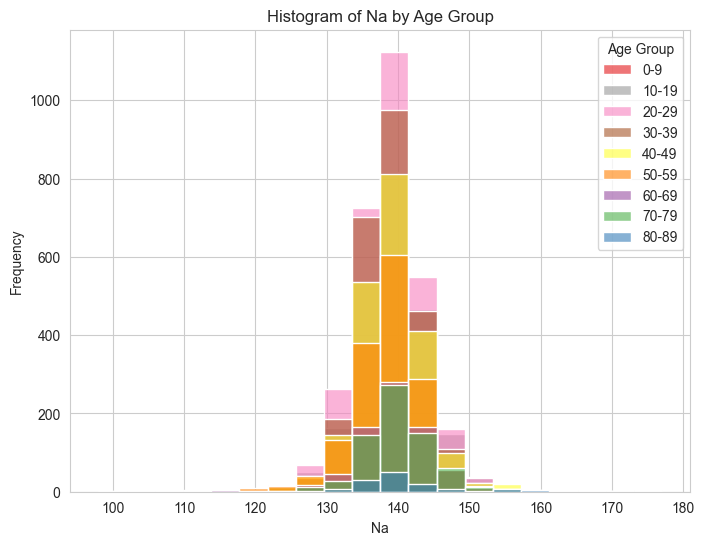

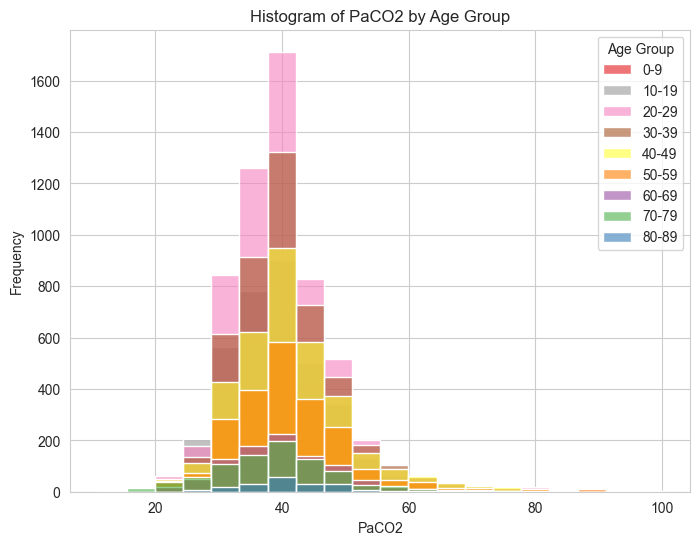

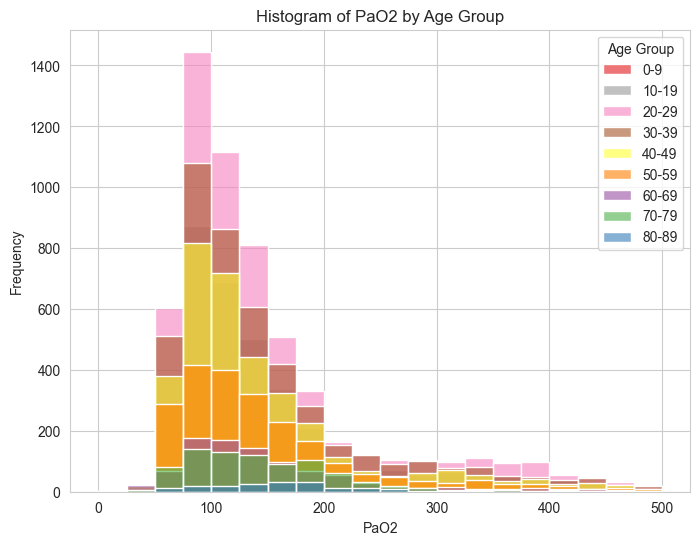

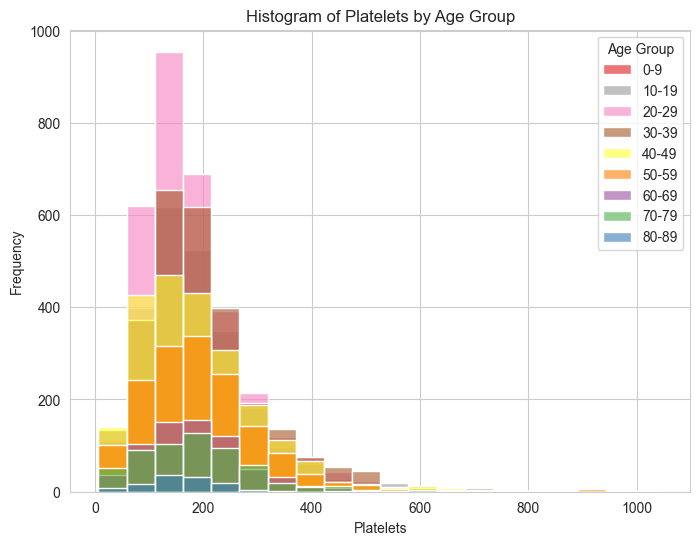

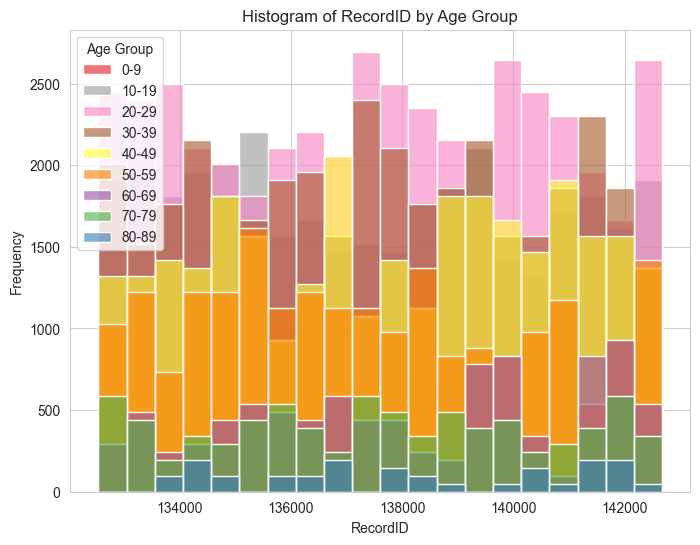

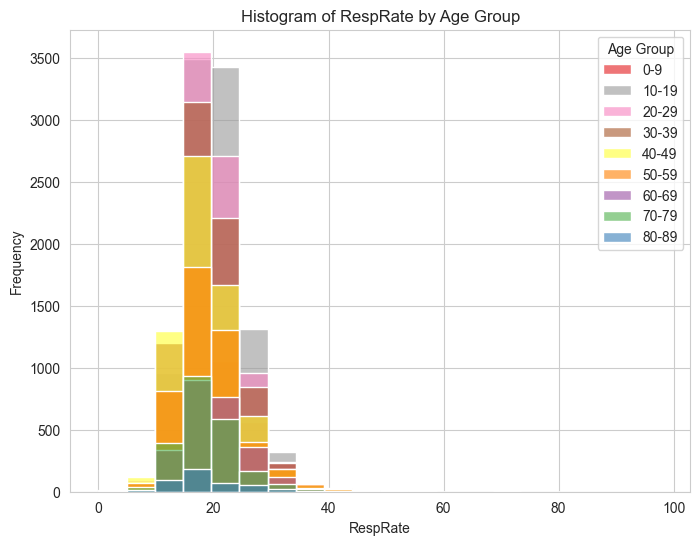

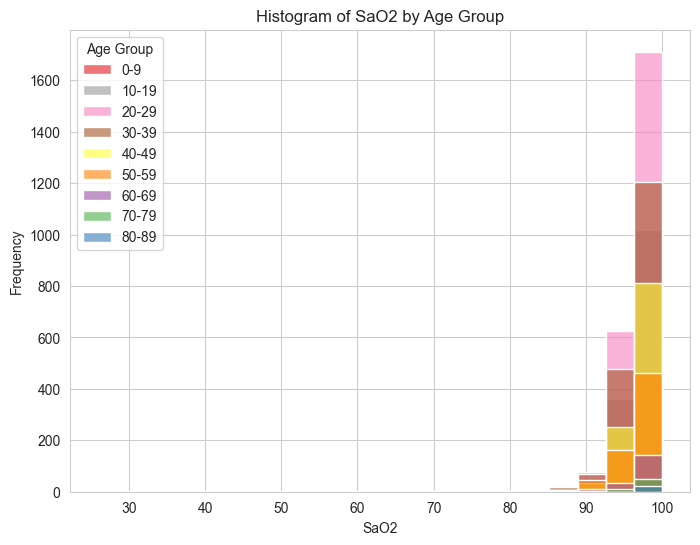

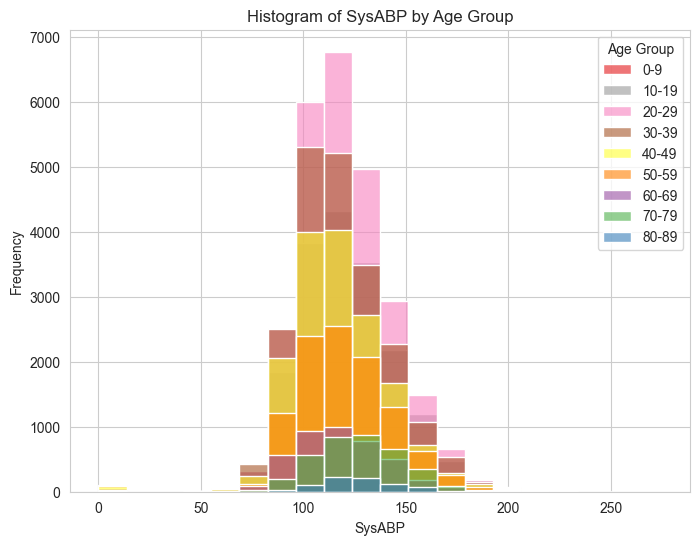

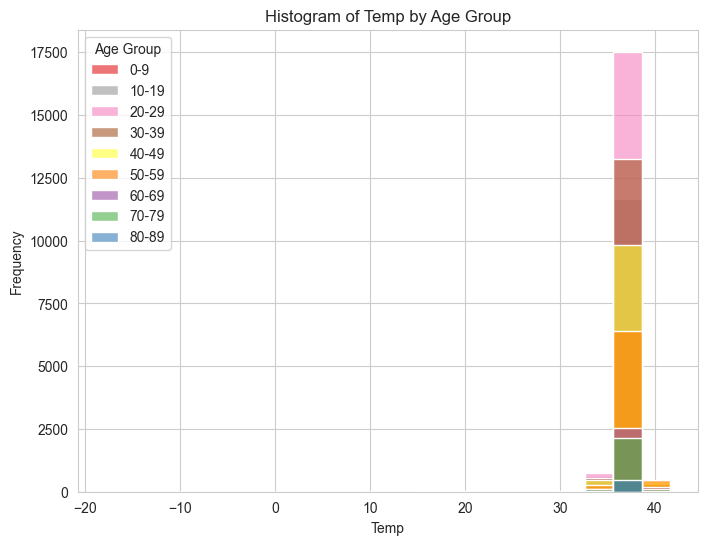

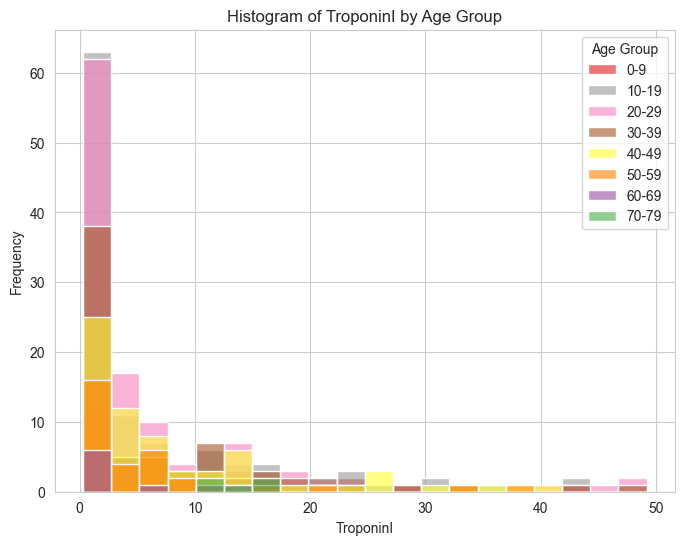

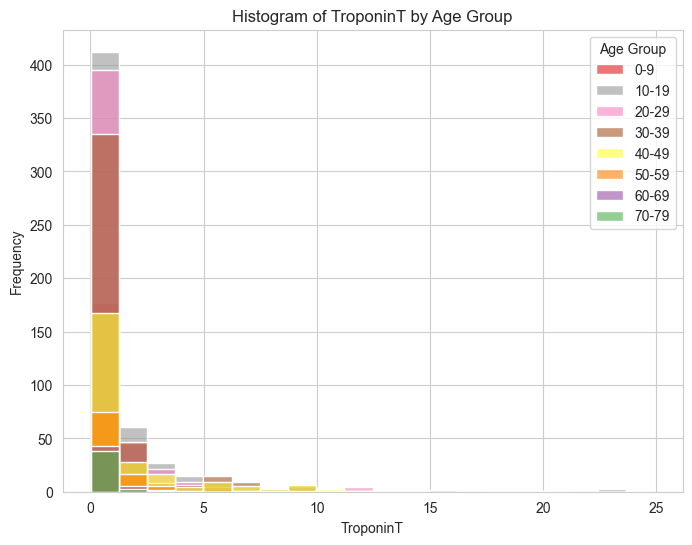

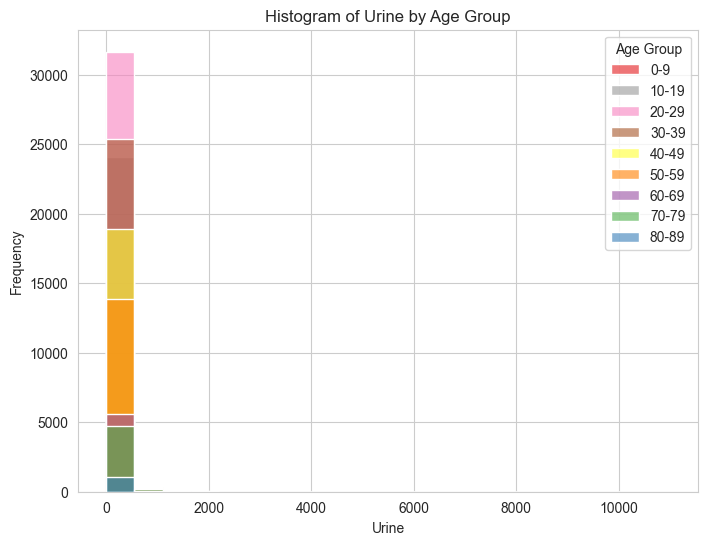

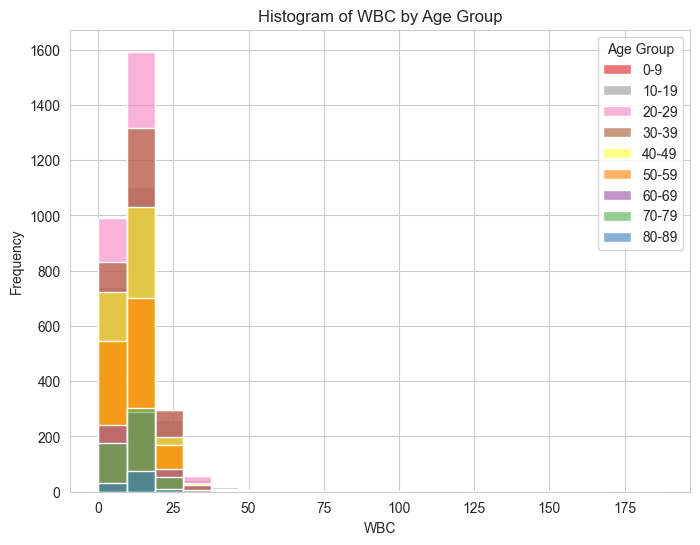

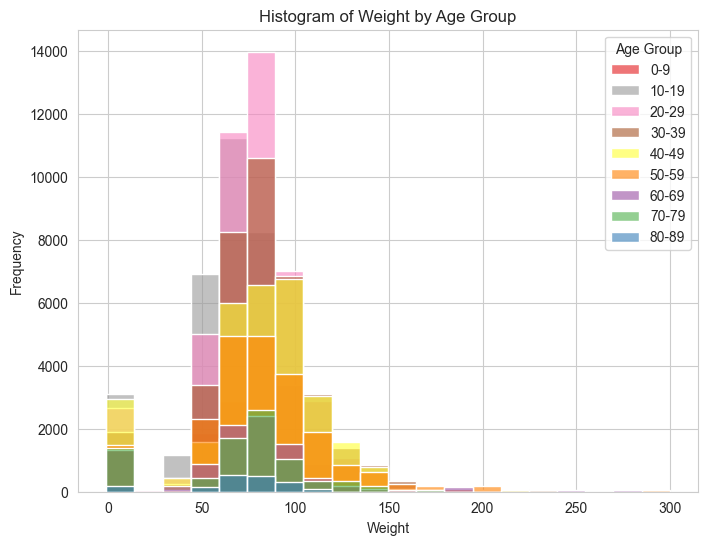

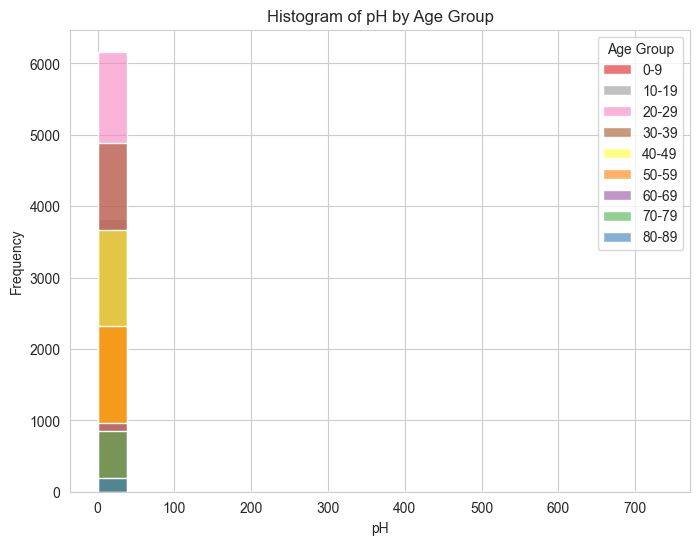

In [8]:
# Histograms of parameters by Age Group

df = pd.read_parquet('processed-data/processed-set-a.parquet')

# Create age bins (e.g., 0-9, 10-19, etc.)
bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
labels = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99"]
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

for e in unique_parameters:
    # Create a histogram by AgeGroup with different colors for each bin
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=e, hue="AgeGroup", bins=20, alpha=0.6, palette="Set1")

    # Add title and labels
    plt.title("Histogram of " + e + " by Age Group")
    plt.xlabel(e)
    plt.ylabel("Frequency")
    plt.legend(title="Age Group", labels=labels)
    plt.show()

# Q1.3 Preprocess data for Machine Learning

Workflow: Forward filling, scaling (standard scaling of continuous variables), zero-filling of entries without previous values.

In [9]:
# Loading datasets and performing forward filling (do this once for each of the processed datasets)
df = pd.read_parquet('processed-data/processed-set-c.parquet')

# Duplicating RecordID so that this column is still present after forward filling
df['RecordID2'] = df.loc[:, 'RecordID']
imputed_df = df.groupby("RecordID2").ffill()
imputed_df.to_parquet('imputed-data/imputed-set-c.parquet', index=False)

### Points to consider for scaling

1. Scaling RecordID: The code is scaling all numeric columns, including RecordID which should be excluded.
2.  Handling for binary/categorical variables: Gender and MechVent are likely binary variables (0/1) that shouldn't be scaled. ICUType is categorical and should be one-hot encoded instead of scaled.
3. Time transformation: The Time column (timestamp format).
4. Scaling across datasets: For train/validation/test splits, we should fit the scaler on the training data only and apply that same transformation to validation and test sets.

In [12]:
train_df = pd.read_parquet('imputed-data/imputed-set-a.parquet')
if 'ICUType' in train_df.columns:
        print("Removing ICUType column as requested")
        train_df = train_df.drop(columns=['ICUType'])

# 2. Process Time column
if 'Time' in train_df.columns and train_df['Time'].dtype == 'object':
    train_df['Time'] = train_df['Time'].apply(lambda x: int(x.split(':')[0]))

# 3. Define columns that should NOT be scaled
id_cols = ['RecordID']
categorical_cols = ['Gender', 'MechVent']
processed_cols = ['Time']  # Already processed to numeric

# 4. Identify columns to scale (numeric excluding the exceptions)
non_scale_cols = id_cols + categorical_cols + processed_cols
numeric_cols = [col for col in train_df.select_dtypes(include=['number']).columns 
                if col not in non_scale_cols]

print("Columns to be scaled:", numeric_cols)

# 5. Fit scaler on training data
scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

# 6. Save the scaler for future use, save the scaled training dataset
if not os.path.exists('models'):
    os.makedirs('models')
joblib.dump(scaler, 'models/feature_scaler.pkl')
train_df.to_parquet('scaled-data/scaled-set-a.parquet', index=False)
train_df.head()

# 8. Now apply the same scaler to validation and test sets
for dataset_name in ['b', 'c']:
    dataset_path = f'imputed-data/imputed-set-{dataset_name}.parquet'
    output_path = f'scaled-data/scaled-set-{dataset_name}.parquet'
    df = pd.read_parquet(dataset_path)
    
    # Process Time column consistently
    if 'Time' in df.columns and df['Time'].dtype == 'object':
        df['Time'] = df['Time'].apply(lambda x: int(x.split(':')[0]))
    
    # Apply the same scaler from training data, save
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    df.to_parquet(output_path, index=False)

Removing ICUType column as requested
Columns to be scaled: ['Age', 'BUN', 'Creatinine', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'K', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'Platelets', 'RespRate', 'Temp', 'TroponinT', 'Urine', 'WBC', 'Weight', 'ALP', 'ALT', 'AST', 'Albumin', 'Bilirubin', 'Cholesterol', 'DiasABP', 'FiO2', 'Lactate', 'MAP', 'PaCO2', 'PaO2', 'SaO2', 'SysABP', 'TroponinI', 'pH']


In [13]:
# Zero-filling after scaling, do this for all data sets
df = pd.read_parquet('scaled-data/scaled-set-c.parquet')

# Count NaN values before zero-filling
nan_count_before = df[numeric_cols].isna().sum().sum()
print(f"NaN values before zero-filling: {nan_count_before}")

# Apply zero-filling to numeric columns
for col in numeric_cols:
    df[col] = df[col].fillna(0)

# Count NaN values after zero-filling
nan_count_after = df[numeric_cols].isna().sum().sum()
print(f"NaN values after zero-filling: {nan_count_after}")

# Save the zero-filled dataset
df.to_parquet('final-data/final-set-c.parquet', index=False)

NaN values before zero-filling: 2580784
NaN values after zero-filling: 0
